# Estimating CAPEX/OPEX for Mini-grids
<br>

**Conceptualization, Methodology & Code:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br> **Funding:** SEforALL

## Rationale

... 
<br>

---


# Step 1. Setting up python env & Importing datasets

## Import necessary modules

As part of any modeling exercise in jupyter, the first step requires that the necessary python modules are imported. You may refer to the [requirements.txt]() to check dependencies for this notebook.

In [168]:
# Import python modules
import geopandas as gpd
import pandas as pd
import pyproj
import numpy as np
import fiona
import time
import json

from functools import reduce
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import nearest_points

#import datapane as dp
#!datapane login --token="yourpersonaltoken"
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"

import folium
from folium.features import GeoJsonTooltip
import branca.colormap as cm
import os
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline

## Importing datasets

Here we import the datasets that we are going to work with. These include the following three:

**1. Administrative boundaries (vector polygon):** This defines the boundary box over our area of interest. In this example we use the administrative boundaries of Mecanhelas, a province in north-western Mozambique. You may retrieve this from [GADM](https://gadm.org/) 

**2. Locations of health facilities (vector points)**: In this case we use a spatial database of health facilities provided by [Maina et al.](https://www.nature.com/articles/s41597-019-0142-2). The dataset consists of 98745 public health facilities in Sub-Sahara Africa, all of which are geolocated.

**3. Population clusters (vector polygons)**: This refers to a vectorized version of built-up areas as described and developed by [Korkovelos et al.](https://www.mdpi.com/1996-1073/12/7/1395). Population clusters for all countries in Sub-Saharan Africa are open access and available at [PopClusters](https://data.mendeley.com/datasets/z9zfhzk8cr/6). (In this exercise we use Version 6 released 01-09-2020).

<br>

> **Note 1**. For the purposes of this exercise both (2) and (3) have been clipped based on (1) before being imported in the notebook. You may used [geopandas](https://geopandas.org/reference/geopandas.clip.html) or [Qgis](https://docs.qgis.org/2.8/en/docs/user_manual/processing_algs/gdalogr/ogr_geoprocessing/clipvectorsbypolygon.html) to do this.

> **Note 2**. All datasets are in WGS84 coordinate systems prior importing. Please make sure that this is the case and correct if otherwise.

In [148]:
cntry = "Zambia"
cntryc = "zm"

In [166]:
# Define path and name of the file#

ROOT_DIR = os.path.abspath(os.curdir)
admin_path = ROOT_DIR + "\\" + 'Input_Data'
Data_MERRA= admin_path + "\\"+"Data_MERRA"

admin_name = "{}_admin.gpkg".format(cntryc)

# Define path and name of the file
mg_path = ROOT_DIR + "\\" + 'Input_Data' + '\\' + 'VIDA_Oct_18_2023'
mg_name = "VIDA_all_settlements_18102023.gpkg"

#Administrative_Layer
admin_map= ROOT_DIR + "\\" + 'Input_Data' + '\\' + "{}_admin.gpkg".format(cntryc)

# Define path and name of the file
clusters_path = ROOT_DIR + "\\" + 'Input_Data'
#clusters_name = "{}-2-0_0_0_0_1_0.csv".format(cntryc)
#clusters_name = "mw-2-0_0_0_0_1_0.csv"

# Path of solar resource data
T2M_data= Data_MERRA + "\\" + 'T2M_centroids'
GHI_data= Data_MERRA + "\\" + 'GHI_centroids'
path_solar_t2m = ROOT_DIR + "\\" + 'Input_Data' + "\\" + "Data_MERRA"+ "\\" + 'centroids_GHI_T2M.json'

# Path of result files
outpath= ROOT_DIR + "\\" + 'Output_Data'
#outpath= r"C:\Users\alexl\Dropbox\Self-employment\WBG\Work\GEP\WHO_HF\Literature\Haiti docs"


### Importing admin boundary as geodataframe

In [150]:
# Create a new geo-dataframe
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)

In [151]:
admin_gdf_proj = admin_gdf.to_crs({'init': "EPSG:4326"})

C:\Users\renec\miniconda3\envs\geospatial_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [152]:
admin_gdf_proj.head(4)

,ADM1_NAME,ADM2_NAME,geometry
0,Central,Chibombo,"MULTIPOLYGON (((28.97302 -15.01219, 28.96813 -..."
1,Central,Kabwe,"MULTIPOLYGON (((28.58818 -14.31777, 28.59200 -..."
2,Central,Kapiri-Mposhi,"MULTIPOLYGON (((28.52884 -13.85634, 28.53400 -..."
3,Central,Mkushi,"MULTIPOLYGON (((29.80896 -13.45514, 29.80150 -..."


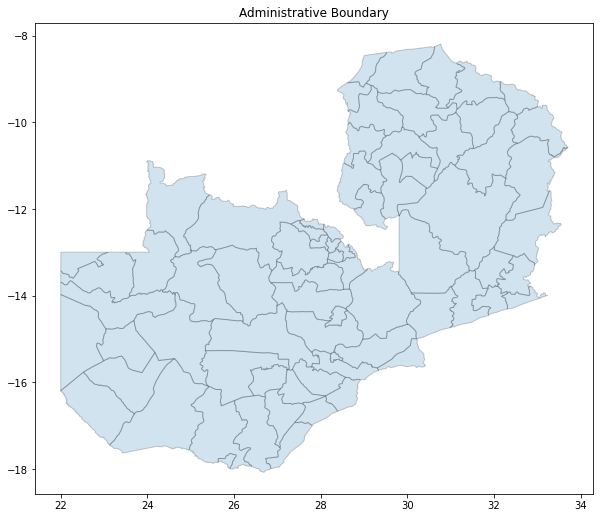

In [153]:
## Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf_proj.plot(ax=ax, edgecolor='black', alpha=0.2)
ax.set_aspect('equal', 'box')
txt = ax.set_title('Administrative Boundary'.format(""))

### Importing mini grids

**Note** that for the code below to work properly this should be a "Point" layer; in case the geometry is characterized as "Multipoint" you should convert it into a "Point" to proceed. You may use [Qgis](http://www.saga-gis.org/saga_tool_doc/3.0.0/shapes_points_15.html) to do this.

In [154]:
# Create a new geo-dataframe
#health_gdf = gpd.read_file(mg_path + "\\" + mg_name)
mg_gdf = gpd.read_file(mg_path + "\\" + mg_name)

In [155]:
# Adding an index column
#health_gdf['hf_id'] = range(1, len(health_gdf)+1)
mg_gdf['mg_id'] = range(1, len(mg_gdf)+1)

In [156]:
mg_gdf.columns

Index(['Lat', 'Lon', 'Site Name', 'Country', 'VIDA_ID', 'Province', 'District',
       'Ratio of built-up area', 'Number of buildings',
       'Number of large buildings', 'Number of medium buildings',
       'Number of small buildings', 'Number of very small structures',
       'Population sum', 'Population estimate', 'Customer density',
       'Distance to the road [km]', 'Distance to nearest hub [km]',
       'Nearest regional hub', 'Distance to railway [km]',
       'Healthcare facilities', 'Education facilities',
       'Average relative wealth index', 'Total points of interest',
       'Top five dominant crops', 'Total crop value [$/year]',
       'Total crop yield [kg/ha]', 'Total crop value per hectare [$/ha]',
       'Percentage of nightlight overlap [%]', 'Has nightlight?',
       'Distance to the nightlight [km]',
       'Distance to nearest hydropower source [km]',
       'Distance to nearest transformer [km]',
       'Distance to nearest substation [km]',
       'Distance 

In [158]:
mg_gdf.shape[0]

24552

In [159]:
#health_gdf_proj = health_gdf.to_crs({'init': 'epsg:4326'})
mg_gdf_proj = mg_gdf.to_crs({'init': 'epsg:4326'})

In [160]:
mg_gdf_proj.head(3)

,Lat,Lon,Site Name,Country,VIDA_ID,Province,District,Ratio of built-up area,Number of buildings,Number of large buildings,...,Distance to nearest mini-grid site [Km],Mini-grid site status,"Fatalities within 50 km (battles,riots,violence against civilians,explosions)","Fatalities within 25 km (battles,riots,violence against civilians,explosions)",Total number of incidents within 25km,Security risk,Travelhours,GHI,geometry,mg_id
0,-9.890335,31.250981,Nseluka,Zambia,24447,Northern,Mungwi,0.01,332.0,0.0,...,27.81,Construction license,"0,2,0,0","0,1,0,0",1,high,0.386625,2032.684937,POINT (31.25098 -9.89033),1
1,-14.486753,30.866770,None,Zambia,16849,Eastern,Nyimba,0.02,164.0,0.0,...,10.15,Reserved,"0,0,0,0","0,0,0,0",0,low,2.183017,1908.004578,POINT (30.86677 -14.48675),2
2,-13.495112,25.903903,None,Zambia,5542,North-Western,Kasempa,0.02,283.0,3.0,...,47.53,Reserved,"0,0,0,0","0,0,0,0",0,low,3.221642,2007.907740,POINT (25.90390 -13.49511),3


#### ... and visualizing 

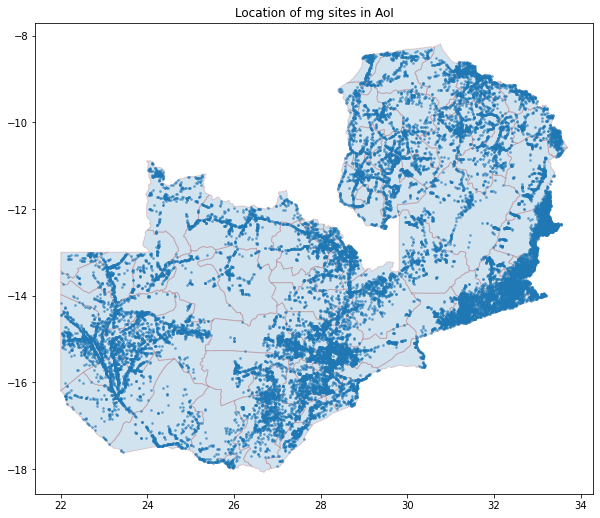

In [161]:
fig, ax = plt.subplots(figsize=(10, 10))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
mg_gdf_proj.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Location of mg sites in AoI'.format(""))

In [162]:
mg_gdf_proj.columns

Index(['Lat', 'Lon', 'Site Name', 'Country', 'VIDA_ID', 'Province', 'District',
       'Ratio of built-up area', 'Number of buildings',
       'Number of large buildings', 'Number of medium buildings',
       'Number of small buildings', 'Number of very small structures',
       'Population sum', 'Population estimate', 'Customer density',
       'Distance to the road [km]', 'Distance to nearest hub [km]',
       'Nearest regional hub', 'Distance to railway [km]',
       'Healthcare facilities', 'Education facilities',
       'Average relative wealth index', 'Total points of interest',
       'Top five dominant crops', 'Total crop value [$/year]',
       'Total crop yield [kg/ha]', 'Total crop value per hectare [$/ha]',
       'Percentage of nightlight overlap [%]', 'Has nightlight?',
       'Distance to the nightlight [km]',
       'Distance to nearest hydropower source [km]',
       'Distance to nearest transformer [km]',
       'Distance to nearest substation [km]',
       'Distance 

In [163]:
mg_gdf_proj["Province"].value_counts()

Eastern          5801
Western          3042
Central          2873
Southern         2569
Northern         2416
Muchinga         1745
North-Western    1695
Lusaka           1535
Luapula          1520
Copperbelt       1356
Name: Province, dtype: int64

In [111]:
mg_gdf_proj["Province"].unique()

array(['Northern', 'Eastern', 'North-Western', 'Muchinga', 'Central',
       'Copperbelt', 'Lusaka', 'Western', 'Luapula', 'Southern'],
      dtype=object)

### Adding GHI and Temperature data

The Global Horizontal Irradiance and temperature should have already been processed to be unpacked whitin the main algorithm. Please check the Jupyter Notebook [Downloading and processing GHI and Temperature information](http://localhost:8888/notebooks/Documents/GitHub/MiniGridOpt/Downloading%20and%20processing%20GHI%20and%20Temperature%20information.ipynb#Import-necessary-modules). As the information stored in the file [centroids_GHI_T2M.json](http://localhost:8888/edit/Documents/GitHub/MiniGridOpt/Input_Data/Data_MERRA/centroids_GHI_T2M.json) contains the name of the centroids, it is necessary to perform a spatial join to retrieve GHI and temperature values from the JSON file.

In [164]:
# Perform a spatial join
mg_gdf_proj = gpd.sjoin(mg_gdf_proj, admin_gdf, how="left", op="within")


<ipython-input-164-b8fc50435f63>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  mg_gdf_proj = gpd.sjoin(mg_gdf_proj, admin_gdf, how="left", op="within")


In [113]:
mg_gdf_proj

,Lat,Lon,Site Name,Country,VIDA_ID,Province,District,Ratio of built-up area,Number of buildings,Number of large buildings,...,"Fatalities within 25 km (battles,riots,violence against civilians,explosions)",Total number of incidents within 25km,Security risk,Travelhours,GHI,geometry,mg_id,index_right,ADM1_NAME,ADM2_NAME
0,-9.890335,31.250981,Nseluka,Zambia,24447,Northern,Mungwi,0.01,332.0,0.0,...,"0,1,0,0",1,high,0.386625,2032.684937,POINT (31.25098 -9.89033),1,52.0,Northern,Mungwi
1,-14.486753,30.866770,None,Zambia,16849,Eastern,Nyimba,0.02,164.0,0.0,...,"0,0,0,0",0,low,2.183017,1908.004578,POINT (30.86677 -14.48675),2,22.0,Eastern,Nyimba
2,-13.495112,25.903903,None,Zambia,5542,North-Western,Kasempa,0.02,283.0,3.0,...,"0,0,0,0",0,low,3.221642,2007.907740,POINT (25.90390 -13.49511),3,37.0,North-Western,Kasempa
3,-13.334729,32.929618,None,Zambia,22782,Eastern,Chipangali,0.10,25.0,3.0,...,"0,0,0,0",0,low,2.087193,1991.628585,POINT (32.92962 -13.33473),4,18.0,Eastern,Chipata
4,-13.485709,25.893190,None,Zambia,3619,North-Western,Kasempa,0.02,299.0,0.0,...,"0,0,0,0",0,low,3.171341,2006.690999,POINT (25.89319 -13.48571),5,37.0,North-Western,Kasempa
5,-10.936067,30.092136,Chaba,Zambia,56,Northern,Chilubi,0.02,423.0,1.0,...,"0,0,0,0",0,low,1.248513,2053.231240,POINT (30.09214 -10.93607),6,42.0,Northern,Chilubi
6,-11.096882,30.217005,None,Zambia,24482,Northern,Chilubi,0.03,256.0,0.0,...,"0,0,0,0",0,low,1.979773,2063.054430,POINT (30.21700 -11.09688),7,42.0,Northern,Chilubi
7,-9.955222,29.963595,None,Zambia,16334,Northern,Lunte,0.02,140.0,1.0,...,"0,0,0,0",0,low,1.848559,1968.787399,POINT (29.96359 -9.95522),8,50.0,Northern,Mporokoso
8,-12.402135,33.325680,Mwase Lundazi,Zambia,7316,Eastern,Lundazi,0.06,105.0,0.0,...,"0,0,0,0",0,low,1.011650,1969.410787,POINT (33.32568 -12.40213),9,20.0,Eastern,Lundazi
9,-10.438464,32.058317,None,Zambia,9657,Muchinga,Chinsali,0.03,105.0,0.0,...,"0,0,0,0",0,low,0.459243,2030.129883,POINT (32.05832 -10.43846),10,43.0,Northern,Chinsali


In [170]:
# Open the file in read mode
try:
  with open(path_solar_t2m, "r") as f:
    # Load the content of the file as a dictionary
    data_GHI_T2M = json.load(f)

except FileNotFoundError:
  print(f"Error: File '{filename}' not found.")

except json.JSONDecodeError:
  print(f"Error: Invalid JSON format in '{filename}'.")

# Importing population clusters

In [115]:
# clusters_gdf = pd.read_csv(clusters_path + "\\" + clusters_name)

In [116]:
#clusters_gdf.head(2)

In [117]:
#for i in clusters_gdf.columns:
#    print (i)

#### Assign result to the mg df to proceed as usual

In [191]:
#MG = result_df
MG = mg_gdf_proj

In [192]:
MG.columns

Index(['Lat', 'Lon', 'Site Name', 'Country', 'VIDA_ID', 'Province', 'District',
       'Ratio of built-up area', 'Number of buildings',
       'Number of large buildings', 'Number of medium buildings',
       'Number of small buildings', 'Number of very small structures',
       'Population sum', 'Population estimate', 'Customer density',
       'Distance to the road [km]', 'Distance to nearest hub [km]',
       'Nearest regional hub', 'Distance to railway [km]',
       'Healthcare facilities', 'Education facilities',
       'Average relative wealth index', 'Total points of interest',
       'Top five dominant crops', 'Total crop value [$/year]',
       'Total crop yield [kg/ha]', 'Total crop value per hectare [$/ha]',
       'Percentage of nightlight overlap [%]', 'Has nightlight?',
       'Distance to the nightlight [km]',
       'Distance to nearest hydropower source [km]',
       'Distance to nearest transformer [km]',
       'Distance to nearest substation [km]',
       'Distance 


### Invest & Cap estimation

In [193]:
def assignLoadFactor(cs):
    if (cs == '1'):
        return 0.15
    elif (cs == '2'):
        return 0.16
    elif (cs == '3'):
        return 0.21
    else:
        return 0    

In [194]:
def assignLoadTier(cs):
    if (cs == '1'):
        return 1
    elif (cs == '2'):
        return 2
    elif (cs == '3'):
        return 3
    else:
        return 0

### Estimate PV-diesel MG configuration for HF

In [195]:
def pv_diesel_hybrid(
        bba, 
        bbb, 
        bbc, 
        bbpme, 
        bbprod, 
        centroid,  
        diesel_price,
        start_year,
        end_year,
        pv_cost_factor,
        diesel_cost=325,  # diesel generator capital cost, USD/kWA rated power
        pv_no=1,  # number of PV panel sizes simulated
        diesel_no=1,  # number of diesel generators simulated
        discount_rate=0.138,
):
    n_chg = 0.92  # charge efficiency of battery
    n_dis = 0.92  # discharge efficiency of battery
    lpsp_max = 0.01  # maximum loss of load allowed over the year, in share of kWh ## 0.0001
    battery_cost = 593  # battery capital capital cost, USD/kWh of storage capacity
    pv_cost = 720 * 1  # PV panel capital cost, USD/kW peak power
    pv_life = 25  # PV panel expected lifetime, years
    diesel_life = 10  # diesel generator expected lifetime, years
    pv_om = 0.015  # annual OM cost of PV panels
    diesel_om = 0.1  # annual OM cost of diesel generator
    k_t = 0.005  # temperature factor of PV panels
    inverter_cost = 230
    inverter_life = 10
    inv_eff = 0.92  # inverter_efficiency
    charge_controller = 250
    sgna = 18 # $/connection/year

    #ghi = ghi_curve * ghi * 1000 / ghi_curve.sum()
    hour_numbers = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23) * 365
    dod_max = 0.8  # maximum depth of discharge of battery

    def load_curves(bba, bbb, bbc, bbpme, bbprod):
        # the values below define the load curve for the five tiers. The values reflect the share of the daily demand
        # expected in each hour of the day (sum of all values for one tier = 1)
        ba_load_curve = [0.988074348, 0.83234137, 0.780348447, 0.895071886, 1.29452897, 1.427317285,
                         1.427143895, 2.036533853, 2.788021073, 3.132621618, 3.398067297, 3.597146625,
                         3.749088177, 3.619622164, 3.645379008, 3.798564636, 4.140905488, 6.288317305,
                         9.012611343, 8.343100334, 6.300316324, 3.931731497, 2.193525721, 1.379620337]
        
        bb_load_curve = [3.184482155, 2.873016199, 2.769030352, 2.99847723, 3.797391399, 4.062968029, 
                         4.062621248, 5.281401164, 6.784375605, 7.473576694, 8.004468052, 8.402626707, 
                         8.706509811, 8.447577786, 8.499091475, 8.805462731, 9.490144434, 13.78496807, 
                         19.23355614, 17.89453413, 13.80896611, 9.071796452, 5.5953849, 3.967574132]
        
        bc_load_curve = [8.923873354, 8.047396638, 7.614331638, 7.763438133, 9.507818801, 12.4321089,
                         13.48321774, 14.41446325, 15.87567906, 16.28469545, 17.16546017, 17.7633564,
                         18.49249621, 19.22393746, 19.1473699, 18.37923754, 17.41429094, 23.6968058, 
                         40.54912477, 48.55186439, 44.0975794, 32.05947574, 19.32369079, 11.78828855]
        
        bpme_load_curve = [0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098,
                           7.645880133, 18.30034088, 30.36078872, 42.83318642, 49.9405017, 52.93860082,
                           49.93452555, 44.38491667, 35.85872985, 27.40653484, 20.76932651, 32.56118326,
                           62.28781859, 74.50081552, 62.8359663, 36.32711164, 17.17269706, 4.690252421]
        
        bprod_load_curve = [12.51341557,  12.49088602, 12.47672647, 16.65231446, 21.62811274, 73.12221043, 
                            307.3487742, 619.3246364, 907.5906364, 919.5741762, 1038.177627, 1124.612654,
                            1022.608964, 896.7845886, 959.4059058, 857.2820323, 729.2917592, 482.4635076,
                            108.3151878, 50.78451089, 60.39546483, 26.100591, 13.54589784, 12.50942015]

        
        ba_load_curve = [i * bba for i in ba_load_curve]
        bb_load_curve = [i * bbb for i in bb_load_curve]
        bc_load_curve = [i * bbc for i in bc_load_curve]
        bpme_load_curve = [i * bbpme for i in bpme_load_curve]
        bprod_load_curve = [i * bbprod for i in bprod_load_curve]
        
        load_curve = [sum(x) for x in zip(ba_load_curve, bb_load_curve, bc_load_curve, bpme_load_curve, bprod_load_curve )] * 365

        load_curve = [i / 1000 for i in load_curve]
        
        return np.array(load_curve) 
    
    load_curve = load_curves(bba, bbb, bbc, bbpme, bbprod)
    energy_per_hh = (sum(load_curves(bba, bbb, bbc, bbpme, bbprod)))

    def pv_diesel_capacities(pv_capacity, battery_size, diesel_capacity, pv_no, diesel_no, battery_no):
        dod = np.zeros(shape=(24, battery_no, pv_no, diesel_no))
        battery_use = np.zeros(shape=(24, battery_no, pv_no, diesel_no))  # Stores the amount of battery discharge during the day
        fuel_result = np.zeros(shape=(battery_no, pv_no, diesel_no))
        battery_life = np.zeros(shape=(battery_no, pv_no, diesel_no))
        soc = np.ones(shape=(battery_no, pv_no, diesel_no)) * 0.5
        unmet_demand = np.zeros(shape=(battery_no, pv_no, diesel_no))
        excess_gen = np.zeros(shape=(battery_no, pv_no, diesel_no))  # TODO
        annual_diesel_gen = np.zeros(shape=(battery_no, pv_no, diesel_no))
        dod_max = np.ones(shape=(battery_no, pv_no, diesel_no)) * 0.6
        
        def get_ghi_t2m_arrays(data_GHI_T2M, centroid):
            for data in data_dict:
                if data['name'] == centroid:
                    return np.array(data['GHI']), np.array(data['T2M'])
            return None, None

        ghi, temp = get_ghi_t2m_arrays(data_GHI_T2M, centroid)

    
        for i in range(8760):

            # Battery self-discharge (0.02% per hour)
            battery_use[hour_numbers[i], :, :] = 0.0002 * soc
            soc *= 0.9998

            # Calculation of PV gen and net load
            t_cell = temp[i] + 0.0256 * ghi[i]  # PV cell temperature
            pv_gen = pv_capacity * 0.9 * ghi[i] / 1000 * (1 - k_t * (t_cell - 25))  # PV generation in the hour
            net_load = load_curve[hour_numbers[i]] - pv_gen * inv_eff  # remaining load not met by PV panels

            # Dispatchable energy from battery available to meet load
            battery_dispatchable = soc * battery_size * n_dis * inv_eff
            # Energy required to fully charge battery
            battery_chargeable = (1 - soc) * battery_size / n_chg / inv_eff

            # Below is the dispatch strategy for the diesel generator as described in word document

            if 4 < hour_numbers[i] <= 17:
                # During the morning and day, the batteries are dispatched primarily.
                # The diesel generator, if needed, is run at the lowest possible capacity

                # Minimum diesel capacity to cover the net load after batteries.
                # Diesel genrator limited by lowest possible capacity (40%) and rated capacity
                min_diesel = np.minimum(
                    np.maximum(net_load - battery_dispatchable, 0.4 * diesel_capacity),
                    diesel_capacity)

                diesel_gen = np.where(net_load > battery_dispatchable, min_diesel, 0)

            elif 17 > hour_numbers[i] > 23:
                # During the evening, the diesel generator is dispatched primarily, at max_diesel.
                # Batteries are dispatched if diesel generation is insufficient.

                #  Maximum amount of diesel needed to supply load and charge battery
                # Diesel genrator limited by lowest possible capacity (40%) and rated capacity
                max_diesel = np.maximum(
                    np.minimum(net_load + battery_chargeable, diesel_capacity),
                    0.4 * diesel_capacity)

                diesel_gen = np.where(net_load > 0, max_diesel, 0)
            else:
                # During night, batteries are dispatched primarily.
                # The diesel generator is used at max_diesel if load is larger than battery capacity

                #  Maximum amount of diesel needed to supply load and charge battery
                # Diesel genrator limited by lowest possible capacity (40%) and rated capacity
                max_diesel = np.maximum(
                    np.minimum(net_load + battery_chargeable, diesel_capacity),
                    0.4 * diesel_capacity)

                diesel_gen = np.where(net_load > battery_dispatchable, max_diesel, 0)

            fuel_result += np.where(diesel_gen > 0, diesel_capacity * 0.08145 + diesel_gen * 0.246, 0)
            annual_diesel_gen += diesel_gen

            # Reamining load after diesel generator
            net_load = net_load - diesel_gen

            # If diesel generation is used, but is smaller than load, battery is discharged
            soc -= np.where((net_load > 0) & (diesel_gen > 0),
                            net_load / n_dis / inv_eff / battery_size,
                            0)

            # If diesel generation is used, and is larger than load, battery is charged
            soc -= np.where((net_load < 0) & (diesel_gen > 0),
                            net_load * n_chg * inv_eff / battery_size,
                            0)

            # If net load is positive and no diesel is used, battery is discharged
            soc -= np.where((net_load > 0) & (diesel_gen == 0),
                            net_load / n_dis / battery_size,
                            0)

            # If net load is negative, and no diesel has been used, excess PV gen is used to charge battery
            soc -= np.where((net_load < 0) & (diesel_gen == 0),
                            net_load * n_chg / battery_size,
                            0)


            # The amount of battery discharge in the hour is stored (measured in State Of Charge)
            battery_use[hour_numbers[i], :, :] = \
                np.minimum(np.where(net_load > 0,
                                    net_load / n_dis / battery_size,
                                    0),
                           soc)

            # If State of charge is negative, that means there's demand that could not be met.
            unmet_demand += np.where(soc < 0,
                                     -soc / n_dis * battery_size,
                                     0)
            soc = np.maximum(soc, 0)

            # If State of Charge is larger than 1, that means there was excess PV/diesel generation
            excess_gen += np.where(soc > 1,
                                   (soc - 1) / n_chg * battery_size,
                                   0)
            # TODO
            soc = np.minimum(soc, 1)

            dod[hour_numbers[i], :, :] = 1 - soc  # The depth of discharge in every hour of the day is stored
            if hour_numbers[i] == 23:  # The battery wear during the last day is calculated
                battery_used = np.where(dod.max(axis=0) > 0, 1, 0)
                battery_life += battery_use.sum(axis=0) / (
                        531.52764 * np.maximum(0.1, dod.max(axis=0) * dod_max) ** -1.12297) * battery_used

        condition = unmet_demand / energy_per_hh  # LPSP is calculated
        excess_gen = excess_gen / energy_per_hh
        battery_life = np.round(1 / battery_life)
        diesel_share = annual_diesel_gen / energy_per_hh

        return diesel_share, battery_life, condition, fuel_result, excess_gen

    # This section creates the range of PV capacities, diesel capacities and battery sizes to be simulated
    ref = 5 * load_curve[19]

    battery_sizes = [energy_per_hh / 365]
    pv_caps = []
    diesel_caps = []
    diesel_extend = np.ones(pv_no)
    pv_extend = np.ones(diesel_no)

    for i in range(pv_no):
        pv_caps.append(ref * (pv_no - i) / pv_no)

    for j in range(diesel_no):
        diesel_caps.append(j * max(load_curve) / diesel_no)

    pv_caps = np.outer(np.array(pv_caps), pv_extend)
    diesel_caps = np.outer(diesel_extend, np.array(diesel_caps))

    # This section creates 2d-arrays to store information on PV capacities, diesel capacities, battery sizes,
    # fuel usage, battery life and LPSP

    battery_size = np.ones((len(battery_sizes), pv_no, diesel_no))
    pv_panel_size = np.zeros((len(battery_sizes), pv_no, diesel_no))
    diesel_capacity = np.zeros((len(battery_sizes), pv_no, diesel_no))

    for j in range(len(battery_sizes)):
        battery_size[j, :, :] *= battery_sizes[j]
        pv_panel_size[j, :, :] = pv_caps
        diesel_capacity[j, :, :] = diesel_caps

    # For the number of diesel, pv and battery capacities the lpsp, battery lifetime, fuel usage and LPSP is calculated
    diesel_share, battery_life, lpsp, fuel_usage, excess_gen = \
        pv_diesel_capacities(pv_panel_size, battery_size, diesel_capacity, pv_no, diesel_no, len(battery_sizes))
    battery_life = np.minimum(20, battery_life)

    def calculate_hybrid_lcoe(diesel_price):
        # Necessary information for calculation of LCOE is defined
        project_life = end_year - start_year
        generation = np.ones(project_life) * energy_per_hh
        generation[0] = 0

        # Calculate LCOE
        sum_costs = np.zeros((len(battery_sizes), pv_no, diesel_no))
        sum_el_gen = np.zeros((len(battery_sizes), pv_no, diesel_no))
        investment = np.zeros((len(battery_sizes), pv_no, diesel_no))
        gen_opex = np.zeros((len(battery_sizes), pv_no, diesel_no))
        sgna_opex = np.zeros((len(battery_sizes), pv_no, diesel_no))

        for year in range(project_life + 1):
            salvage = np.zeros((len(battery_sizes), pv_no, diesel_no))

            fuel_costs = fuel_usage * diesel_price
            om_costs = (pv_panel_size * (pv_cost + charge_controller) * pv_om + diesel_capacity * diesel_cost * diesel_om)
            sgna_costs = (bba+bbb+bbc+bbpme+bbprod)*sgna
            om_costsy1 = (pv_panel_size * (pv_cost + charge_controller) * pv_om + diesel_capacity * diesel_cost * diesel_om)[0][0][0]
            sgna_costsy1 = (bba+bbb+bbc+bbpme+bbprod)*sgna
            
            #print (om_costsy1, sgna_costsy1)

            inverter_investment = np.where(year % inverter_life == 0, max(load_curve) * inverter_cost, 0)
            diesel_investment = np.where(year % diesel_life == 0, diesel_capacity * diesel_cost, 0)
            pv_investment = np.where(year % pv_life == 0, pv_panel_size * (pv_cost + charge_controller), 0)
            battery_investment = np.where(year % battery_life == 0, battery_size * battery_cost / dod_max, 0)  # TODO Include dod_max here?

            if year == project_life:
                salvage = (1 - (project_life % battery_life) / battery_life) * battery_cost * battery_size / dod_max + \
                          (1 - (project_life % diesel_life) / diesel_life) * diesel_capacity * diesel_cost + \
                          (1 - (project_life % pv_life) / pv_life) * pv_panel_size * (pv_cost + charge_controller) + \
                          (1 - (project_life % inverter_life) / inverter_life) * max(load_curve) * inverter_cost

            #investment += diesel_investment + pv_investment + battery_investment + inverter_investment - salvage
            investment += (diesel_investment + pv_investment + battery_investment + inverter_investment - salvage) / ((1 + discount_rate) ** year)
            
            #gen_opex and sgna opex
            gen_opex += om_costs / ((1 + discount_rate) ** year)
            sgna_opex += sgna_costs / ((1 + discount_rate) ** year)
            
            sum_costs += (fuel_costs + om_costs + sgna_costs + diesel_investment + pv_investment + battery_investment + inverter_investment - salvage) / ((1 + discount_rate) ** year)
                
            if year > 0:
                sum_el_gen += energy_per_hh / ((1 + discount_rate) ** year)
        
        return sum_costs / sum_el_gen, investment, gen_opex, om_costsy1, sgna_opex, sgna_costsy1, sum_costs, fuel_usage     ### use "sum_costs" to get the NPV of all lifetime costs; change to "investment" to get the CAPEX (second option discounted)

    diesel_limit = 0.5

    min_lcoe_range = []
    investment_range = []
    opex_gen_range = []
    opex_geny1_range = []
    opex_sgna_range = []
    opex_sgnay1_range = []
    npv_costs_range = []
    capacity_range = []
    ren_share_range = []
    #diesel_cap_range = []
    bat_size_range = []
    fuel_usage_range = []
    
    diesel_range = [diesel_price]

    for d in diesel_range:

        lcoe, investment, gen_opex, gen_opexy1, sgna_opex, sgna_opexy1, npv_costs, fuel_u = calculate_hybrid_lcoe(d)
        lcoe = np.where(lpsp > lpsp_max, 999999, lcoe)
        lcoe = np.where(diesel_share > diesel_limit, 999999, lcoe)

        min_lcoe = np.min(lcoe)
        min_lcoe_combination = np.unravel_index(np.argmin(lcoe, axis=None), lcoe.shape)
        ren_share = 1 - diesel_share[min_lcoe_combination]
        capacity = pv_panel_size[min_lcoe_combination] + diesel_capacity[min_lcoe_combination]
        ren_capacity = pv_panel_size[min_lcoe_combination]
        diesel_capacity = diesel_capacity[min_lcoe_combination]
        bat_size = battery_size[min_lcoe_combination]
        excess_gen = excess_gen[min_lcoe_combination]
        #fu = fu[min_lcoe_combination]

        min_lcoe_range.append(min_lcoe)
        investment_range.append(investment[min_lcoe_combination])
        opex_gen_range.append(gen_opex[min_lcoe_combination])
        opex_geny1_range.append(gen_opexy1)
        opex_sgna_range.append(sgna_opex[min_lcoe_combination])
        opex_sgnay1_range.append(sgna_opexy1)
        npv_costs_range.append(npv_costs[min_lcoe_combination])
        capacity_range.append(capacity)
        ren_share_range.append(ren_share)
        #diesel_cap_range.append(diesel_capacity)
        bat_size_range.append(bat_size)
        fuel_usage_range.append(fuel_u[min_lcoe_combination])
        
        lcoe_hmg = round(min_lcoe_range[0], 4)
        inv_hmg = round(investment_range[0], 2)
        opexgen_hmg = round(opex_gen_range[0], 2)
        opexgeny1_hmg = round(opex_geny1_range[0], 2)
        opexsgna_hmg = round(opex_sgna_range[0], 2)
        opexsgnay1_hmg = round(opex_sgnay1_range[0], 2)
        npv_hmg = round(npv_costs_range[0], 2)
        cap_hmg = round(capacity_range[0], 2)
        ren_share_hmg = round(ren_share_range[0], 3)
        bat_size_hmg = round(bat_size_range[0], 2)
        fu_hmg = round(fuel_usage_range[0], 2)

    #return min_lcoe_range, investment_range, capacity_range, ren_capacity, diesel_capacity, ren_share_range, excess_gen.
    return list((lcoe_hmg, inv_hmg, opexgen_hmg, opexgeny1_hmg, opexsgna_hmg, opexsgnay1_hmg, npv_hmg, cap_hmg, 
                 round(ren_capacity,2), round(diesel_capacity,3), ren_share_hmg, bat_size_hmg, fu_hmg, round(energy_per_hh,2)))

In [196]:
def MG_diesel_fuel_cost(diesel_price, travel_hours):
    '''
    Szabo formula is: p = (p_d + 2*p_d*consumption*time/volume)*(1/mu)*(1/LHVd)
    
    '''
    diesel_truck_consumption = 14
    diesel_truck_volume = 300
    LHV_DIESEL = 9.9445485
    efficiency = 0.33
    
    fuel_cost = (diesel_price + 
                 (2 * diesel_price * diesel_truck_consumption * travel_hours / diesel_truck_volume / LHV_DIESEL) / efficiency)
    
    return fuel_cost

In [197]:
MG["avg_diesel_price"] = 1

In [198]:
MG["MG_diesel_cost"] = MG.apply(lambda row: MG_diesel_fuel_cost(row["avg_diesel_price"], row["Travelhours"]), axis=1)

In [199]:
reasonablecons = 0.7
smeshare = 0.08
bundleCshare = 0.08
bundleBshare = 0.36


MG["VIDA_Conn_All"] = np.ceil(MG["Number of very small structures"] + 
                               MG["Number of small buildings"]+ 
                               MG["Number of medium buildings"]+ 
                               MG["Number of large buildings"]).astype(int)

MG["VIDA_Pot_Con"] = np.ceil(MG["VIDA_Conn_All"]*reasonablecons)

def assignPUoE(a, b, c, d, e):
    puoe = int(round(-2.913362564 + (-0.00415764*a) + (0.008440603*b) + (0.016433547*c) + (0.722331464*d) + (-0.040674586*e),0))
    if puoe <=0:
        return 0
    else:
        return puoe

MG["PUoE"] = MG.apply(lambda row: assignPUoE(row["Number of very small structures"],
                                             row["Number of small buildings"],
                                             row["Number of medium buildings"],
                                             row["Number of large buildings"],
                                             row["Distance to nearest solar mill [Km]"]), axis=1)

MG["SME"] = np.ceil((MG["VIDA_Pot_Con"] - MG["PUoE"])*smeshare)
    
MG["ResC"] = np.ceil((MG["VIDA_Pot_Con"] - MG["PUoE"])*bundleCshare)
                     
MG["ResB"] = np.ceil((MG["VIDA_Pot_Con"] - MG["PUoE"])*bundleBshare)
                     
MG["ResA"] = (MG["VIDA_Pot_Con"] - MG["PUoE"] - MG["SME"] - MG["ResC"]- MG["ResB"])

In [200]:
MG.head(4)

,Lat,Lon,Site Name,Country,VIDA_ID,Province,District,Ratio of built-up area,Number of buildings,Number of large buildings,...,ADM2_NAME,avg_diesel_price,MG_diesel_cost,VIDA_Conn_All,VIDA_Pot_Con,PUoE,SME,ResC,ResB,ResA
0,-9.890335,31.250981,Nseluka,Zambia,24447,Northern,Mungwi,0.01,332.0,0.0,...,Mungwi,1,1.010996,413,290.0,0,24.0,24.0,105.0,137.0
1,-14.486753,30.866770,None,Zambia,16849,Eastern,Nyimba,0.02,164.0,0.0,...,Nyimba,1,1.062086,205,144.0,0,12.0,12.0,52.0,68.0
2,-13.495112,25.903903,None,Zambia,5542,North-Western,Kasempa,0.02,283.0,3.0,...,Kasempa,1,1.091625,396,278.0,1,23.0,23.0,100.0,131.0
3,-13.334729,32.929618,None,Zambia,22782,Eastern,Chipangali,0.10,25.0,3.0,...,Chipata,1,1.059361,30,21.0,0,2.0,2.0,8.0,9.0


## Filtering sites

In [201]:
MG = MG[(MG["Number of buildings"] <= 15)]
# & (MG["Number of buildings"] < 500)

In [202]:
MG

,Lat,Lon,Site Name,Country,VIDA_ID,Province,District,Ratio of built-up area,Number of buildings,Number of large buildings,...,ADM2_NAME,avg_diesel_price,MG_diesel_cost,VIDA_Conn_All,VIDA_Pot_Con,PUoE,SME,ResC,ResB,ResA
178,-15.211028,24.074249,None,Zambia,5501,Western,Luampa,0.03,12.0,0.0,...,Mongu,1,1.077499,16,12.0,0,1.0,1.0,5.0,5.0
1764,-15.743679,26.059094,Itezhi-Tezhi,Zambia,4594,Central,Itezhi-Tezhi,0.01,13.0,0.0,...,Itezhi-tezhi,1,1.073466,17,12.0,0,1.0,1.0,5.0,5.0
2081,-10.466605,30.242122,None,Zambia,19780,Northern,Luwingu,0.02,15.0,0.0,...,Luwingu,1,1.048028,16,12.0,0,1.0,1.0,5.0,5.0
2082,-10.692687,29.760025,None,Zambia,5729,Northern,Lupososhi,0.03,15.0,0.0,...,Luwingu,1,1.067475,16,12.0,0,1.0,1.0,5.0,5.0
4642,-12.038472,31.326298,Kaole,Zambia,14978,Muchinga,Mpika,0.04,11.0,0.0,...,Mpika,1,1.009261,12,9.0,0,1.0,1.0,4.0,3.0
4662,-12.020715,24.091817,Kamapanda,Zambia,19028,North-Western,Mwinilunga,0.03,13.0,0.0,...,Mwinilunga,1,1.022763,18,13.0,0,2.0,2.0,5.0,4.0
4969,-8.844500,31.543022,Kawimbe Mission,Zambia,19838,Northern,Mbala,0.02,12.0,0.0,...,Mbala,1,1.018117,15,11.0,0,1.0,1.0,4.0,5.0
5363,-12.407314,26.131805,None,Zambia,14228,North-Western,Kalumbila,0.03,14.0,0.0,...,Solwezi,1,1.012571,18,13.0,0,2.0,2.0,5.0,4.0
5717,-10.235162,31.066090,None,Zambia,10106,Northern,Kasama,0.01,15.0,0.0,...,Kasama,1,1.005459,16,12.0,0,1.0,1.0,5.0,5.0
6384,-12.874836,28.002725,None,Zambia,15256,Copperbelt,Kalulushi,0.02,13.0,0.0,...,Kalulushi,1,1.009871,15,11.0,0,1.0,1.0,4.0,5.0


In [203]:
start = time.time()
MG["hybrids"] = MG.apply(lambda row: pv_diesel_hybrid(row["ResA"],
                                                      row["ResB"],
                                                      row["ResC"],
                                                      row["SME"],
                                                      row["PUoE"],
                                                      row["ADM2_NAME"],
                                                      row["MG_diesel_cost"],
                                                      2023,
                                                      2043,
                                                      1, 
                                                      diesel_cost=325, 
                                                      pv_no=20, 
                                                      diesel_no=20, 
                                                      discount_rate=0.13), axis=1)
end = time.time()
print((end - start)/60, "min")

9.001610934734344 min


C:\Users\renec\miniconda3\envs\geospatial_env\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [204]:
MG['hybrids']

178      [0.7897, 3167.43, 89.06, 18.5, 1733.35, 216.0,...
1764     [0.7897, 3167.43, 89.06, 18.5, 1733.35, 216.0,...
2081     [0.8113, 3288.6, 103.9, 18.5, 1733.35, 216.0, ...
2082     [0.8113, 3288.6, 103.9, 18.5, 1733.35, 216.0, ...
4642     [0.7661, 2779.53, 83.35, 15.98, 1300.01, 162.0...
4662     [0.7476, 4718.07, 150.78, 26.84, 1877.79, 234....
4969     [0.81, 3044.13, 96.59, 17.19, 1588.9, 198.0, 4...
5363     [0.7367, 4630.15, 140.01, 26.84, 1877.79, 234....
5717     [0.8113, 3288.6, 103.9, 18.5, 1733.35, 216.0, ...
6384     [0.7992, 2987.81, 89.69, 17.19, 1588.9, 198.0,...
6574     [0.7661, 2779.53, 83.35, 15.98, 1300.01, 162.0...
6839     [0.8075, 3266.62, 88.27, 18.5, 1733.35, 216.0,...
6882     [0.7832, 2883.67, 86.52, 16.59, 1444.46, 180.0...
7099     [0.7367, 4630.15, 140.01, 26.84, 1877.79, 234....
7256     [0.7257, 4542.24, 129.24, 26.84, 1877.79, 234....
8055     [0.7992, 2987.81, 89.69, 17.19, 1588.9, 198.0,...
8058     [0.7298, 2389.09, 67.75, 14.07, 1011.12, 126.0.

In [205]:
start = time.time()

MG[['HGM_lcoe','HMG_Inv', 'HMG_GenOpex', 'HMG_GenOpex_y', 'HMG_SGnAOpex', 'HMG_SGnAOpex_y', 
    'HMG_npv_cost', 'HMG_cap', 'HMG_ren_cap', 'HMG_dl_cap', 'HMG_ren_share', 'HMG_bat_size', 'HMG_fuel_usage', 
    'Est_dem_kWh_year']] = pd.DataFrame(MG.hybrids.tolist(), index= MG.index)

end = time.time()
print((end - start)/60, "min")

0.1953980843226115 min


In [207]:
MG['Potential PV production [kWh/kWp]']

178      4.63
1764     4.66
2081     4.50
2082     4.57
4642     4.62
4662     4.41
4969     4.46
5363     4.49
5717     4.53
6384     4.49
6574     4.55
6839     4.50
6882     4.53
7099     4.51
7256     4.54
8055     4.52
8058     4.64
8122     4.26
8123     4.63
8124     4.52
8142     4.57
8150     4.35
8190     4.52
8293     4.47
8301     4.65
9942     4.57
10075    4.41
10298    4.41
10305    4.55
10306    4.66
         ... 
18850    4.51
19194    4.51
19817    4.36
19872    4.57
20192    4.70
20327    4.49
20340    4.48
20389    4.50
20529    4.53
20910    4.73
21265    4.64
21566    4.52
21755    4.63
21899    4.40
22089    4.47
22842    4.66
23081    4.42
23220    4.50
23223    4.53
23225    4.54
23406    4.59
23631    4.53
23632    4.42
23861    4.52
23932    4.52
23968    4.50
23978    4.51
23984    4.50
24261    4.51
24358    4.46
Name: Potential PV production [kWh/kWp], Length: 112, dtype: float64

In [206]:
MG.columns

Index(['Lat', 'Lon', 'Site Name', 'Country', 'VIDA_ID', 'Province', 'District',
       'Ratio of built-up area', 'Number of buildings',
       'Number of large buildings', 'Number of medium buildings',
       'Number of small buildings', 'Number of very small structures',
       'Population sum', 'Population estimate', 'Customer density',
       'Distance to the road [km]', 'Distance to nearest hub [km]',
       'Nearest regional hub', 'Distance to railway [km]',
       'Healthcare facilities', 'Education facilities',
       'Average relative wealth index', 'Total points of interest',
       'Top five dominant crops', 'Total crop value [$/year]',
       'Total crop yield [kg/ha]', 'Total crop value per hectare [$/ha]',
       'Percentage of nightlight overlap [%]', 'Has nightlight?',
       'Distance to the nightlight [km]',
       'Distance to nearest hydropower source [km]',
       'Distance to nearest transformer [km]',
       'Distance to nearest substation [km]',
       'Distance 

In [86]:
#for i in HF.columns:
#    print (i)

### Fixing sites with lcoe bug

In [208]:
MG_diesel = MG[MG["HGM_lcoe"] > 10]

In [209]:
MG_diesel.drop(['hybrids', 'HGM_lcoe','HMG_Inv', 'HMG_GenOpex', 'HMG_GenOpex_y', 'HMG_SGnAOpex', 'HMG_SGnAOpex_y', 
    'HMG_npv_cost', 'HMG_cap', 'HMG_ren_cap', 'HMG_dl_cap', 'HMG_ren_share', 'HMG_bat_size', 'HMG_fuel_usage', 
    'Est_dem_kWh_year'], axis=1, inplace=True)

C:\Users\renec\miniconda3\envs\geospatial_env\lib\site-packages\pandas\core\frame.py:3937: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).drop(labels=labels, axis=axis,


In [210]:
def pv_diesel_hybrid(
        bba, 
        bbb, 
        bbc, 
        bbpme, 
        bbprod, 
        centroid,  
        diesel_price,
        start_year,
        end_year,
        pv_cost_factor,
        diesel_cost=325,  # diesel generator capital cost, USD/kWA rated power
        pv_no=1,  # number of PV panel sizes simulated
        diesel_no=1,  # number of diesel generators simulated
        discount_rate=0.138,
):
    n_chg = 0.92  # charge efficiency of battery
    n_dis = 0.92  # discharge efficiency of battery
    lpsp_max = 0.01  # maximum loss of load allowed over the year, in share of kWh ## 0.0001
    battery_cost = 593  # battery capital capital cost, USD/kWh of storage capacity
    pv_cost = 720 * 1  # PV panel capital cost, USD/kW peak power
    pv_life = 25  # PV panel expected lifetime, years
    diesel_life = 10  # diesel generator expected lifetime, years
    pv_om = 0.015  # annual OM cost of PV panels
    diesel_om = 0.1  # annual OM cost of diesel generator
    k_t = 0.005  # temperature factor of PV panels
    inverter_cost = 230
    inverter_life = 10
    inv_eff = 0.92  # inverter_efficiency
    charge_controller = 250
    sgna = 18 # $/connection/year

    #ghi = ghi_curve * ghi * 1000 / ghi_curve.sum()
    hour_numbers = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23) * 365
    dod_max = 0.8  # maximum depth of discharge of battery

    def load_curves(bba, bbb, bbc, bbpme, bbprod):
        # the values below define the load curve for the five tiers. The values reflect the share of the daily demand
        # expected in each hour of the day (sum of all values for one tier = 1)
        ba_load_curve = [0.988074348, 0.83234137, 0.780348447, 0.895071886, 1.29452897, 1.427317285,
                         1.427143895, 2.036533853, 2.788021073, 3.132621618, 3.398067297, 3.597146625,
                         3.749088177, 3.619622164, 3.645379008, 3.798564636, 4.140905488, 6.288317305,
                         9.012611343, 8.343100334, 6.300316324, 3.931731497, 2.193525721, 1.379620337]
        
        bb_load_curve = [3.184482155, 2.873016199, 2.769030352, 2.99847723, 3.797391399, 4.062968029, 
                         4.062621248, 5.281401164, 6.784375605, 7.473576694, 8.004468052, 8.402626707, 
                         8.706509811, 8.447577786, 8.499091475, 8.805462731, 9.490144434, 13.78496807, 
                         19.23355614, 17.89453413, 13.80896611, 9.071796452, 5.5953849, 3.967574132]
        
        bc_load_curve = [8.923873354, 8.047396638, 7.614331638, 7.763438133, 9.507818801, 12.4321089,
                         13.48321774, 14.41446325, 15.87567906, 16.28469545, 17.16546017, 17.7633564,
                         18.49249621, 19.22393746, 19.1473699, 18.37923754, 17.41429094, 23.6968058, 
                         40.54912477, 48.55186439, 44.0975794, 32.05947574, 19.32369079, 11.78828855]
        
        bpme_load_curve = [0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098,
                           7.645880133, 18.30034088, 30.36078872, 42.83318642, 49.9405017, 52.93860082,
                           49.93452555, 44.38491667, 35.85872985, 27.40653484, 20.76932651, 32.56118326,
                           62.28781859, 74.50081552, 62.8359663, 36.32711164, 17.17269706, 4.690252421]
        
        bprod_load_curve = [12.51341557,  12.49088602, 12.47672647, 16.65231446, 21.62811274, 73.12221043, 
                            307.3487742, 619.3246364, 907.5906364, 919.5741762, 1038.177627, 1124.612654,
                            1022.608964, 896.7845886, 959.4059058, 857.2820323, 729.2917592, 482.4635076,
                            108.3151878, 50.78451089, 60.39546483, 26.100591, 13.54589784, 12.50942015]

        
        ba_load_curve = [i * bba for i in ba_load_curve]
        bb_load_curve = [i * bbb for i in bb_load_curve]
        bc_load_curve = [i * bbc for i in bc_load_curve]
        bpme_load_curve = [i * bbpme for i in bpme_load_curve]
        bprod_load_curve = [i * bbprod for i in bprod_load_curve]
        
        load_curve = [sum(x) for x in zip(ba_load_curve, bb_load_curve, bc_load_curve, bpme_load_curve, bprod_load_curve )] * 365

        load_curve = [i / 1000 for i in load_curve]
        
        return np.array(load_curve) 
    
    load_curve = load_curves(bba, bbb, bbc, bbpme, bbprod)
    energy_per_hh = (sum(load_curves(bba, bbb, bbc, bbpme, bbprod)))

    def pv_diesel_capacities(pv_capacity, battery_size, diesel_capacity, pv_no, diesel_no, battery_no):
        dod = np.zeros(shape=(24, battery_no, pv_no, diesel_no))
        battery_use = np.zeros(shape=(24, battery_no, pv_no, diesel_no))  # Stores the amount of battery discharge during the day
        fuel_result = np.zeros(shape=(battery_no, pv_no, diesel_no))
        battery_life = np.zeros(shape=(battery_no, pv_no, diesel_no))
        soc = np.ones(shape=(battery_no, pv_no, diesel_no)) * 0.5
        unmet_demand = np.zeros(shape=(battery_no, pv_no, diesel_no))
        excess_gen = np.zeros(shape=(battery_no, pv_no, diesel_no))  # TODO
        annual_diesel_gen = np.zeros(shape=(battery_no, pv_no, diesel_no))
        dod_max = np.ones(shape=(battery_no, pv_no, diesel_no)) * 0.6
        
        def get_ghi_t2m_arrays(data_GHI_T2M, centroid):
            for data in data_dict:
                if data['name'] == centroid:
                    return np.array(data['GHI']), np.array(data['T2M'])
            return None, None

        ghi, temp = get_ghi_t2m_arrays(data_GHI_T2M, centroid)

    
        for i in range(8760):

            # Battery self-discharge (0.02% per hour)
            battery_use[hour_numbers[i], :, :] = 0.0002 * soc
            soc *= 0.9998

            # Calculation of PV gen and net load
            t_cell = temp[i] + 0.0256 * ghi[i]  # PV cell temperature
            pv_gen = pv_capacity * 0.9 * ghi[i] / 1000 * (1 - k_t * (t_cell - 25))  # PV generation in the hour
            net_load = load_curve[hour_numbers[i]] - pv_gen * inv_eff  # remaining load not met by PV panels

            # Dispatchable energy from battery available to meet load
            battery_dispatchable = soc * battery_size * n_dis * inv_eff
            # Energy required to fully charge battery
            battery_chargeable = (1 - soc) * battery_size / n_chg / inv_eff

            # Below is the dispatch strategy for the diesel generator as described in word document

            if 4 < hour_numbers[i] <= 17:
                # During the morning and day, the batteries are dispatched primarily.
                # The diesel generator, if needed, is run at the lowest possible capacity

                # Minimum diesel capacity to cover the net load after batteries.
                # Diesel genrator limited by lowest possible capacity (40%) and rated capacity
                min_diesel = np.minimum(
                    np.maximum(net_load - battery_dispatchable, 0.4 * diesel_capacity),
                    diesel_capacity)

                diesel_gen = np.where(net_load > battery_dispatchable, min_diesel, 0)

            elif 17 > hour_numbers[i] > 23:
                # During the evening, the diesel generator is dispatched primarily, at max_diesel.
                # Batteries are dispatched if diesel generation is insufficient.

                #  Maximum amount of diesel needed to supply load and charge battery
                # Diesel genrator limited by lowest possible capacity (40%) and rated capacity
                max_diesel = np.maximum(
                    np.minimum(net_load + battery_chargeable, diesel_capacity),
                    0.4 * diesel_capacity)

                diesel_gen = np.where(net_load > 0, max_diesel, 0)
            else:
                # During night, batteries are dispatched primarily.
                # The diesel generator is used at max_diesel if load is larger than battery capacity

                #  Maximum amount of diesel needed to supply load and charge battery
                # Diesel genrator limited by lowest possible capacity (40%) and rated capacity
                max_diesel = np.maximum(
                    np.minimum(net_load + battery_chargeable, diesel_capacity),
                    0.4 * diesel_capacity)

                diesel_gen = np.where(net_load > battery_dispatchable, max_diesel, 0)

            fuel_result += np.where(diesel_gen > 0, diesel_capacity * 0.08145 + diesel_gen * 0.246, 0)
            annual_diesel_gen += diesel_gen

            # Reamining load after diesel generator
            net_load = net_load - diesel_gen

            # If diesel generation is used, but is smaller than load, battery is discharged
            soc -= np.where((net_load > 0) & (diesel_gen > 0),
                            net_load / n_dis / inv_eff / battery_size,
                            0)

            # If diesel generation is used, and is larger than load, battery is charged
            soc -= np.where((net_load < 0) & (diesel_gen > 0),
                            net_load * n_chg * inv_eff / battery_size,
                            0)

            # If net load is positive and no diesel is used, battery is discharged
            soc -= np.where((net_load > 0) & (diesel_gen == 0),
                            net_load / n_dis / battery_size,
                            0)

            # If net load is negative, and no diesel has been used, excess PV gen is used to charge battery
            soc -= np.where((net_load < 0) & (diesel_gen == 0),
                            net_load * n_chg / battery_size,
                            0)


            # The amount of battery discharge in the hour is stored (measured in State Of Charge)
            battery_use[hour_numbers[i], :, :] = \
                np.minimum(np.where(net_load > 0,
                                    net_load / n_dis / battery_size,
                                    0),
                           soc)

            # If State of charge is negative, that means there's demand that could not be met.
            unmet_demand += np.where(soc < 0,
                                     -soc / n_dis * battery_size,
                                     0)
            soc = np.maximum(soc, 0)

            # If State of Charge is larger than 1, that means there was excess PV/diesel generation
            excess_gen += np.where(soc > 1,
                                   (soc - 1) / n_chg * battery_size,
                                   0)
            # TODO
            soc = np.minimum(soc, 1)

            dod[hour_numbers[i], :, :] = 1 - soc  # The depth of discharge in every hour of the day is stored
            if hour_numbers[i] == 23:  # The battery wear during the last day is calculated
                battery_used = np.where(dod.max(axis=0) > 0, 1, 0)
                battery_life += battery_use.sum(axis=0) / (
                        531.52764 * np.maximum(0.1, dod.max(axis=0) * dod_max) ** -1.12297) * battery_used

        condition = unmet_demand / energy_per_hh  # LPSP is calculated
        excess_gen = excess_gen / energy_per_hh
        battery_life = np.round(1 / battery_life)
        diesel_share = annual_diesel_gen / energy_per_hh

        return diesel_share, battery_life, condition, fuel_result, excess_gen

    # This section creates the range of PV capacities, diesel capacities and battery sizes to be simulated
    ref = 5 * load_curve[19]

    battery_sizes = [energy_per_hh / 365]
    pv_caps = []
    diesel_caps = []
    diesel_extend = np.ones(pv_no)
    pv_extend = np.ones(diesel_no)

    for i in range(pv_no):
        pv_caps.append(ref * (pv_no - i) / pv_no)

    for j in range(diesel_no):
        diesel_caps.append(j * max(load_curve) / diesel_no)

    pv_caps = np.outer(np.array(pv_caps), pv_extend)
    diesel_caps = np.outer(diesel_extend, np.array(diesel_caps))

    # This section creates 2d-arrays to store information on PV capacities, diesel capacities, battery sizes,
    # fuel usage, battery life and LPSP

    battery_size = np.ones((len(battery_sizes), pv_no, diesel_no))
    pv_panel_size = np.zeros((len(battery_sizes), pv_no, diesel_no))
    diesel_capacity = np.zeros((len(battery_sizes), pv_no, diesel_no))

    for j in range(len(battery_sizes)):
        battery_size[j, :, :] *= battery_sizes[j]
        pv_panel_size[j, :, :] = pv_caps
        diesel_capacity[j, :, :] = diesel_caps

    # For the number of diesel, pv and battery capacities the lpsp, battery lifetime, fuel usage and LPSP is calculated
    diesel_share, battery_life, lpsp, fuel_usage, excess_gen = \
        pv_diesel_capacities(pv_panel_size, battery_size, diesel_capacity, pv_no, diesel_no, len(battery_sizes))
    battery_life = np.minimum(20, battery_life)

    def calculate_hybrid_lcoe(diesel_price):
        # Necessary information for calculation of LCOE is defined
        project_life = end_year - start_year
        generation = np.ones(project_life) * energy_per_hh
        generation[0] = 0

        # Calculate LCOE
        sum_costs = np.zeros((len(battery_sizes), pv_no, diesel_no))
        sum_el_gen = np.zeros((len(battery_sizes), pv_no, diesel_no))
        investment = np.zeros((len(battery_sizes), pv_no, diesel_no))
        gen_opex = np.zeros((len(battery_sizes), pv_no, diesel_no))
        sgna_opex = np.zeros((len(battery_sizes), pv_no, diesel_no))

        for year in range(project_life + 1):
            salvage = np.zeros((len(battery_sizes), pv_no, diesel_no))

            fuel_costs = fuel_usage * diesel_price
            om_costs = (pv_panel_size * (pv_cost + charge_controller) * pv_om + diesel_capacity * diesel_cost * diesel_om)
            sgna_costs = (bba+bbb+bbc+bbpme+bbprod)*sgna
            om_costsy1 = (pv_panel_size * (pv_cost + charge_controller) * pv_om + diesel_capacity * diesel_cost * diesel_om)[0][0][0]
            sgna_costsy1 = (bba+bbb+bbc+bbpme+bbprod)*sgna
            
            #print (om_costsy1, sgna_costsy1)

            inverter_investment = np.where(year % inverter_life == 0, max(load_curve) * inverter_cost, 0)
            diesel_investment = np.where(year % diesel_life == 0, diesel_capacity * diesel_cost, 0)
            pv_investment = np.where(year % pv_life == 0, pv_panel_size * (pv_cost + charge_controller), 0)
            battery_investment = np.where(year % battery_life == 0, battery_size * battery_cost / dod_max, 0)  # TODO Include dod_max here?

            if year == project_life:
                salvage = (1 - (project_life % battery_life) / battery_life) * battery_cost * battery_size / dod_max + \
                          (1 - (project_life % diesel_life) / diesel_life) * diesel_capacity * diesel_cost + \
                          (1 - (project_life % pv_life) / pv_life) * pv_panel_size * (pv_cost + charge_controller) + \
                          (1 - (project_life % inverter_life) / inverter_life) * max(load_curve) * inverter_cost

            #investment += diesel_investment + pv_investment + battery_investment + inverter_investment - salvage
            investment += (diesel_investment + pv_investment + battery_investment + inverter_investment - salvage) / ((1 + discount_rate) ** year)
            
            #gen_opex and sgna opex
            gen_opex += om_costs / ((1 + discount_rate) ** year)
            sgna_opex += sgna_costs / ((1 + discount_rate) ** year)
            
            sum_costs += (fuel_costs + om_costs + sgna_costs + diesel_investment + pv_investment + battery_investment + inverter_investment - salvage) / ((1 + discount_rate) ** year)
                
            if year > 0:
                sum_el_gen += energy_per_hh / ((1 + discount_rate) ** year)
        
        return sum_costs / sum_el_gen, investment, gen_opex, om_costsy1, sgna_opex, sgna_costsy1, sum_costs, fuel_usage     ### use "sum_costs" to get the NPV of all lifetime costs; change to "investment" to get the CAPEX (second option discounted)

    diesel_limit = 0.5

    min_lcoe_range = []
    investment_range = []
    opex_gen_range = []
    opex_geny1_range = []
    opex_sgna_range = []
    opex_sgnay1_range = []
    npv_costs_range = []
    capacity_range = []
    ren_share_range = []
    #diesel_cap_range = []
    bat_size_range = []
    fuel_usage_range = []
    
    diesel_range = [diesel_price]

    for d in diesel_range:

        lcoe, investment, gen_opex, gen_opexy1, sgna_opex, sgna_opexy1, npv_costs, fuel_u = calculate_hybrid_lcoe(d)
        lcoe = np.where(lpsp > lpsp_max, 999999, lcoe)
        lcoe = np.where(diesel_share > diesel_limit, 999999, lcoe)

        min_lcoe = np.min(lcoe)
        min_lcoe_combination = np.unravel_index(np.argmin(lcoe, axis=None), lcoe.shape)
        ren_share = 1 - diesel_share[min_lcoe_combination]
        capacity = pv_panel_size[min_lcoe_combination] + diesel_capacity[min_lcoe_combination]
        ren_capacity = pv_panel_size[min_lcoe_combination]
        diesel_capacity = diesel_capacity[min_lcoe_combination]
        bat_size = battery_size[min_lcoe_combination]
        excess_gen = excess_gen[min_lcoe_combination]
        #fu = fu[min_lcoe_combination]

        min_lcoe_range.append(min_lcoe)
        investment_range.append(investment[min_lcoe_combination])
        opex_gen_range.append(gen_opex[min_lcoe_combination])
        opex_geny1_range.append(gen_opexy1)
        opex_sgna_range.append(sgna_opex[min_lcoe_combination])
        opex_sgnay1_range.append(sgna_opexy1)
        npv_costs_range.append(npv_costs[min_lcoe_combination])
        capacity_range.append(capacity)
        ren_share_range.append(ren_share)
        #diesel_cap_range.append(diesel_capacity)
        bat_size_range.append(bat_size)
        fuel_usage_range.append(fuel_u[min_lcoe_combination])
        
        lcoe_hmg = round(min_lcoe_range[0], 4)
        inv_hmg = round(investment_range[0], 2)
        opexgen_hmg = round(opex_gen_range[0], 2)
        opexgeny1_hmg = round(opex_geny1_range[0], 2)
        opexsgna_hmg = round(opex_sgna_range[0], 2)
        opexsgnay1_hmg = round(opex_sgnay1_range[0], 2)
        npv_hmg = round(npv_costs_range[0], 2)
        cap_hmg = round(capacity_range[0], 2)
        ren_share_hmg = round(ren_share_range[0], 3)
        bat_size_hmg = round(bat_size_range[0], 2)
        fu_hmg = round(fuel_usage_range[0], 2)

    #return min_lcoe_range, investment_range, capacity_range, ren_capacity, diesel_capacity, ren_share_range, excess_gen.
    return list((lcoe_hmg, inv_hmg, opexgen_hmg, opexgeny1_hmg, opexsgna_hmg, opexsgnay1_hmg, npv_hmg, cap_hmg, 
                 round(ren_capacity,2), round(diesel_capacity,3), ren_share_hmg, bat_size_hmg, fu_hmg, round(energy_per_hh,2)))

In [213]:
start = time.time()
MG_diesel["hybrids"] = MG_diesel.apply(lambda row: pv_diesel_hybrid(row["ResA"],
                                                      row["ResB"],
                                                      row["ResC"],
                                                      row["SME"],
                                                      row["PUoE"],
                                                      row["ADM2_NAME"],
                                                      row["MG_diesel_cost"],
                                                      2023,
                                                      2043,
                                                      1, 
                                                      diesel_cost=325, 
                                                      pv_no=20, 
                                                      diesel_no=20, 
                                                      discount_rate=0.13), axis=1)
end = time.time()
print((end - start)/60, "min")

0.10291935602823893 min


In [215]:
start = time.time()

MG_diesel[['HGM_lcoe','HMG_Inv', 'HMG_GenOpex', 'HMG_GenOpex_y', 'HMG_SGnAOpex', 'HMG_SGnAOpex_y', 
    'HMG_npv_cost', 'HMG_cap', 'HMG_ren_cap', 'HMG_dl_cap', 'HMG_ren_share', 'HMG_bat_size', 'HMG_fuel_usage', 
    'Est_dem_kWh_year']] = pd.DataFrame(MG_diesel.hybrids.tolist(), index= MG_diesel.index)

end = time.time()
print((end - start)/60, "min")

0.22313578128814698 min


In [216]:
# Set the ID column as the index for both data frames
MG.set_index('VIDA_ID', inplace=True)
MG_diesel.set_index('VIDA_ID', inplace=True)

# Update the first data frame with values from the second data frame
MG.update(MG_diesel)

# Reset the index of the first data frame if needed
MG.reset_index(inplace=True)
MG_diesel.reset_index(inplace=True)

In [217]:
#HF.columns.tolist()

In [218]:
#HF.drop([ 'No_of_poles',
# 'Poles_CAPEX',
# 'Cable_CAPEX',
# 'Dist_CAPEX',
# 'Conn_CAPEX',
# 'TdxLC',
# 'PSLC',
# 'Transp_of_mat',
# 'LogInstCAPEX',
# 'Tot_CAPEX',
# 'SGandA_y',
# 'gen_OPEX',
# 'ResAConskWh_y',
# 'ResBConskWh_y',
# 'ResCConskWh_y',
# 'ResSMEConskWh_y',
# 'ResPUoEConskWh_y',
# 'ResARev_y',
# 'ResBRev_y',
# 'ResCRev_y',
# 'ResSMERev_y',
# 'ResPUoERev_y',
# 'ResARev_y_d2',
# 'ResBRev_y_d2',
# 'ResCRev_y_d2',
# 'ResSMERev_y_d2',
# 'ResPUoERev_y_d2',
# 'TotalRev2',
# 'CAPEX_GAP2',
# 'CAPEX_subsidy2',
# 'SGandA_y2',
# 'gen_OPEX_y2',
# 'OPEX_y2',
# 'Total_subsidy2',
# 'ResARev_y_d5',
# 'ResBRev_y_d5',
# 'ResCRev_y_d5',
# 'ResSMERev_y_d5',
# 'ResPUoERev_y_d5',
# 'TotalRev5',
# 'CAPEX_GAP5',
# 'CAPEX_subsidy5',
# 'SGandA_y5',
# 'gen_OPEX_y5',
# 'OPEX_y5',
# 'Total_subsidy5',
# 'ResARev_y_d15',
# 'ResBRev_y_d15',
# 'ResCRev_y_d15',
# 'ResSMERev_y_d15',
# 'ResPUoERev_y_d15',
# 'TotalRev15',
# 'CAPEX_GAP15',
# 'CAPEX_subsidy15',
# 'SGandA_y15',
# 'gen_OPEX_y15',
# 'OPEX_y15',
# 'Total_subsidy15'], axis=1, inplace=True)

In [219]:
#HF.to_csv("UG_test_original_0percentdiesel.csv")

In [220]:
#HF[HF.id == 191587]

In [221]:
MG.head(2)

,VIDA_ID,Lat,Lon,Site Name,Country,Province,District,Ratio of built-up area,Number of buildings,Number of large buildings,...,HMG_SGnAOpex,HMG_SGnAOpex_y,HMG_npv_cost,HMG_cap,HMG_ren_cap,HMG_dl_cap,HMG_ren_share,HMG_bat_size,HMG_fuel_usage,Est_dem_kWh_year
0,5501,-15.211028,24.074249,None,Zambia,Western,Luampa,0.03,12.0,0.0,...,1733.35,216.0,4989.84,0.76,0.76,0.0,1.0,2.46,0.0,899.45
1,4594,-15.743679,26.059094,Itezhi-Tezhi,Zambia,Central,Itezhi-Tezhi,0.01,13.0,0.0,...,1733.35,216.0,4989.84,0.76,0.76,0.0,1.0,2.46,0.0,899.45


### Adding distribution costs

In [222]:
## Poles
pole_dist = 40 #meters
cost_per_pole = 150+26+72.2+34 ## pole + overhead accessories + lightning protection
MG["No_of_poles"] = round(MG['Length of minimum spanning tree [km]']*1000/pole_dist,0)
MG["Poles_CAPEX"] = MG["No_of_poles"]*cost_per_pole

## Cables
trunk_line_cost = 2 #$/meter
MG["Cable_CAPEX"] = round(MG['Length of minimum spanning tree [km]']*1000*trunk_line_cost,0)

## Total sum
MG["Dist_CAPEX"] = MG["Poles_CAPEX"]+MG["Cable_CAPEX"]

### Adding Service drop | Customer connection costs

In [223]:
con_cost = 173 # overhead access. | meter | ready board+rectifier
MG["Conn_CAPEX"] = MG["VIDA_Pot_Con"]*con_cost

### Logistics & installation costs

In [224]:
MG["TdxLC"] = MG["No_of_poles"] * 60  ## Distribution grid labour cost | 60 USD/pole
MG["PSLC"] = MG["HMG_cap"] * 100  ## Distribution grid labour cost | 100 USD/kWp
MG["Transp_of_mat"] = MG["VIDA_Pot_Con"]*27  ## Transportation of material | 27 USD/connection

## Total sum
MG["LogInstCAPEX"] = MG["TdxLC"]+MG["PSLC"]+MG["Transp_of_mat"]

### Total CAPEX

In [225]:
MG["Tot_CAPEX"] = MG['HMG_Inv'] + MG["Dist_CAPEX"] + MG["Conn_CAPEX"] + MG["LogInstCAPEX"]

## OPEX

### Selling general and administrative (SG&A) costs

In [102]:
#sganda_cost_per_con = 18 ## $/connection/year ($1.5/con/month)
#HF["SGandA_y"] = HF["VIDA_Pot_Con"]*sganda_cost_per_con

### Extracting discounted generation OPEX from NPC

In [103]:
#HF["gen_OPEX"] = HF["HMG_npv_cost"] - HF["HMG_Inv"]

In [104]:
#HF = pd.read_csv(r"C:\Users\alexl\Dropbox\Self-employment\SEforALL\Work\Zambia\MG_assess_code\VIDA 5k sites SEforALL sizing and costing estimates Oct2023-new.csv")

In [105]:
#HF.columns

In [106]:
#HF = pd.read_csv(r"C:\Users\alexl\Dropbox\Self-employment\SEforALL\Work\Zambia\MG_assess_code\VIDA 5k sites SEforALL sizing and costing estimates Oct2023.csv")
#HF.drop(['ResAConskWh_y',
#       'ResBConskWh_y', 'ResCConskWh_y', 'ResSMEConskWh_y', 'ResPUoEConskWh_y',
#       'ResARev_y', 'ResBRev_y', 'ResCRev_y', 'ResSMERev_y', 'ResPUoERev_y',
#       'ResARev_y_d', 'ResBRev_y_d', 'ResCRev_y_d', 'ResSMERev_y_d',
#       'ResPUoERev_y_d', 'TotalRev', 'CAPEX_GAP', 'CAPEX_subsidy'], axis=1, inplace=True)

### Subsidy calculation

In [73]:
def calculate_total_revenue(yearly_revenue:float, discount_rate:float, years:int) -> float:
    """
    Calculates the discounted yearly revenue over the next 15 years given a fixed rate.
    :param discount_rate: The fixed rate.
    :param yearly_revenue: the yearly revenue.
    :param years: the number of years
    :return: The discounted revenue.
    """
    
    total_revenue = 0
    for year in range(1, years + 1):
        present_value = yearly_revenue / ((1 + discount_rate) ** year)
        total_revenue += present_value
    return total_revenue

In [74]:
def calculate_sga_opex_npc(yearly_opex:float, discount_rate:float, years:int) -> float:
    npv = 0
    for year in range(1, years + 1):
        present_value = yearly_opex / ((1 + discount_rate) ** year)
        npv += present_value
    return npv

In [75]:
def estimate_annual_gen_opex_costs(npv, discount_rate, num_years, year_stop):
    annual_cost = npv * (discount_rate / (1 - (1 + discount_rate) ** -num_years))
    annual_costs = []
    total_costs = 0
    for current_year in range(1, num_years + 1):
        present_value = annual_cost / ((1 + discount_rate) ** current_year)
        annual_costs.append(present_value)
        if current_year <= year_stop:
            total_costs += present_value
    return total_costs

In [76]:
## Consumption per Bundle per year
MG["ResAConskWh_y"] = MG["ResA"]*78.999999001/1000*365
MG["ResBConskWh_y"] = MG["ResB"]*187.00000100500003/1000*365
MG["ResCConskWh_y"] = MG["ResC"]*462.00000102399997/1000*365
MG["ResSMEConskWh_y"] = MG["SME"]*672.254115472/1000*365
MG["ResPUoEConskWh_y"] = MG["PUoE"]*10284.999999900001/1000*365

In [77]:
## Revenew per Bundle per year
MG["ResARev_y"] = MG["ResAConskWh_y"]*1.45 
MG["ResBRev_y"] = MG["ResBConskWh_y"]*1.17
MG["ResCRev_y"] = MG["ResCConskWh_y"]*0.66
MG["ResSMERev_y"] = MG["ResSMEConskWh_y"]*0.65
MG["ResPUoERev_y"] = MG["ResPUoEConskWh_y"]*0.24

In [112]:
#disc_rate = 0.05
#HF["ResARev_y_d"] = HF.apply(lambda row: calculate_total_revenue(row["ResARev_y"], disc_rate, 15), axis=1)
#HF["ResBRev_y_d"] = HF.apply(lambda row: calculate_total_revenue(row["ResBRev_y"], disc_rate, 15), axis=1)
#HF["ResCRev_y_d"] = HF.apply(lambda row: calculate_total_revenue(row["ResCRev_y"], disc_rate, 15), axis=1)
#HF["ResSMERev_y_d"] = HF.apply(lambda row: calculate_total_revenue(row["ResSMERev_y"], disc_rate, 15), axis=1)
#HF["ResPUoERev_y_d"] = HF.apply(lambda row: calculate_total_revenue(row["ResPUoERev_y"], disc_rate, 15), axis=1)
#
#HF["TotalRev"] = (HF["ResARev_y_d"] + 
#                  HF["ResBRev_y_d"] + 
#                  HF["ResCRev_y_d"] + 
#                  HF["ResSMERev_y_d"]+
#                  HF["ResPUoERev_y_d"])

#HF["CAPEX_GAP"] = HF["Tot_CAPEX"] - HF["TotalRev"]
#HF["CAPEX_subsidy"] = HF["CAPEX_GAP"]/HF["VIDA_Pot_Con"]

#### Functions creating the conversions from real to nominal terms & currency exchange

In [78]:
# Create the infl_dict dictionary
# source: Bank of Zambia 
# data source https://www.statista.com/statistics/457704/inflation-rate-in-zambia/    https://knoema.es/kyaewad/us-inflation-forecast-2022-2023-and-long-term-to-2030-data-and-charts

infl_dict = {
    "Year": list(range(2022, 2051)),
    "Year_index": list(range(0, 29)),
    "infl_zm": [0.069, 0.056, 0.056, 0.056, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050],
    "infl_eur": [0.013, 0.016, 0.018, 0.018, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019],
    "infl_usd": [0.020, 0.019, 0.019, 0.021, 0.022, 0.022, 0.022, 0.021, 0.021, 0.020, 0.020, 0.020, 0.020, 0.020, 0.020, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021, 0.021],
}

# Calculate the multiplier index for each currency
multiplier_infl_dict = {}
for currency in ['infl_zm', 'infl_eur', 'infl_usd']:
    multiplier_infl_dict[currency + '_multiplier'] = [1.0]
    for i in range(1, len(infl_dict[currency])):
        previous_multiplier = multiplier_infl_dict[currency + '_multiplier'][-1]
        new_multiplier = previous_multiplier + (1 * infl_dict[currency][i])
        multiplier_infl_dict[currency + '_multiplier'].append(new_multiplier)

# Add the multiplier index to the original infl_dict dictionary
for currency in ['infl_zm', 'infl_eur', 'infl_usd']:
    infl_dict[currency + '_multiplier'] = multiplier_infl_dict[currency + '_multiplier']

# Add the additional columns
infl_dict["exr_KwToEur"] = [19.65] + [0] * 28
infl_dict["exr_KwToUsd"] = [17.66] + [0] * 28
infl_dict["exr_UsdToEur"] = [1.11] + [0] * 28

# Calculate the exchange rate values from index 1 onward
for i in range(1, len(infl_dict["Year_index"])):
    previous_year_exr_kWToEur = infl_dict["exr_KwToEur"][i - 1]
    previous_year_exr_kWToUsd = infl_dict["exr_KwToUsd"][i - 1]
    previous_year_exr_UsdToEur = infl_dict["exr_UsdToEur"][i - 1]
    
    infl_diff_kWToEur = infl_dict["infl_zm"][i] - infl_dict["infl_eur"][i]
    infl_diff_kWToUsd = infl_dict["infl_zm"][i] - infl_dict["infl_usd"][i]
    infl_diff_UsdToEur = infl_dict["infl_usd"][i] - infl_dict["infl_eur"][i]
    
    infl_dict["exr_KwToEur"][i] = previous_year_exr_kWToEur + previous_year_exr_kWToEur * infl_diff_kWToEur
    infl_dict["exr_KwToUsd"][i] = previous_year_exr_kWToUsd + previous_year_exr_kWToUsd * infl_diff_kWToUsd
    infl_dict["exr_UsdToEur"][i] = previous_year_exr_UsdToEur + previous_year_exr_UsdToEur * infl_diff_UsdToEur
    
# Convert the infl_dict dictionary into a infl_dict
#infl_df = pd.infl_dict(infl_dict)
infl_df = pd.DataFrame.from_dict(infl_dict, orient='index')
infl_df = infl_df.transpose()
infl_df.drop(infl_df.tail(1).index, inplace = True)
infl_df.Year = infl_df.Year.astype(int)

def adjust_fin_flows(value, input_currency, output_currency, year_index, infl_df):
    if input_currency == output_currency:
        # Adjust value using the relevant multiplier
        if input_currency == 'zw':
            multiplier = infl_df.at[year_index, 'infl_zm_multiplier']
        elif input_currency == 'eur':
            multiplier = infl_df.at[year_index, 'infl_eur_multiplier']
        elif input_currency == 'usd':
            multiplier = infl_df.at[year_index, 'infl_usd_multiplier']
        return value * multiplier
    else:
        # Adjust value using the relevant multiplier and exchange rate
        if input_currency == 'zw':
            multiplier = infl_df.at[year_index, 'infl_zm_multiplier']
            if output_currency == 'eur':
                exchange_rate = infl_df.at[year_index, 'exr_KwToEur']
            elif output_currency == 'usd':
                exchange_rate = infl_df.at[year_index, 'exr_KwToUsd']
        elif input_currency == 'eur':
            multiplier = infl_df.at[year_index, 'infl_eur_multiplier']
            if output_currency == 'zw':
                exchange_rate = 1 / infl_df.at[year_index, 'exr_KwToEur']
            elif output_currency == 'usd':
                exchange_rate = infl_df.at[year_index, 'exr_UsdToEur']
        elif input_currency == 'usd':
            multiplier = infl_df.at[year_index, 'infl_usd_multiplier']
            if output_currency == 'zw':
                exchange_rate = 1 / infl_df.at[year_index, 'exr_KwToUsd']
            elif output_currency == 'eur':
                exchange_rate = 1 / infl_df.at[year_index, 'exr_UsdToEur']
        return (value * multiplier) / exchange_rate
    
def calculate_adjusted_values(df, Out_Name, Col_Name, input_currency, output_currency, year_index):
    df[Out_Name] = 0
    for i in range(1, year_index+1):
        df[Out_Name] += df.apply(lambda row: adjust_fin_flows(row[Col_Name], input_currency, output_currency, i, infl_df), axis=1)

### Calculate Revenue & Costs in a given year (X)

In [79]:
MG.columns.to_list()

['Lat',
 'Lon',
 'Site Name',
 'Country',
 'VIDA_ID',
 'Province',
 'District',
 'Ratio of built-up area',
 'Number of buildings',
 'Number of large buildings',
 'Number of medium buildings',
 'Number of small buildings',
 'Number of very small structures',
 'Population sum',
 'Population estimate',
 'Customer density',
 'Distance to the road [km]',
 'Distance to nearest hub [km]',
 'Nearest regional hub',
 'Distance to railway [km]',
 'Healthcare facilities',
 'Education facilities',
 'Average relative wealth index',
 'Total points of interest',
 'Top five dominant crops',
 'Total crop value [$/year]',
 'Total crop yield [kg/ha]',
 'Total crop value per hectare [$/ha]',
 'Percentage of nightlight overlap [%]',
 'Has nightlight?',
 'Distance to the nightlight [km]',
 'Distance to nearest hydropower source [km]',
 'Distance to nearest transformer [km]',
 'Distance to nearest substation [km]',
 'Distance to nearest HV lines [km]',
 'Distance to nearest MV lines [km]',
 'Potential number 

In [80]:
## Year = 2
calculate_adjusted_values(MG, "ResARev_y2", "ResARev_y", 'usd', 'usd', 2)
calculate_adjusted_values(MG, "ResBRev_y2", "ResBRev_y", 'usd', 'usd', 2)
calculate_adjusted_values(MG, "ResCRev_y2", "ResCRev_y", 'usd', 'usd', 2)
calculate_adjusted_values(MG, "ResSMERev_y2", "ResSMERev_y", 'usd', 'usd', 2)
calculate_adjusted_values(MG, "ResPUoERev_y2", "ResPUoERev_y", 'usd', 'usd', 2)

calculate_adjusted_values(MG, "gen_opex_y2", "HMG_GenOpex_y", 'usd', 'usd', 2)
calculate_adjusted_values(MG, "sgna_opex_y2", "HMG_SGnAOpex_y", 'usd', 'usd', 2)

## Sum Revenue for the year
MG["TotalRev2"] = (MG["ResARev_y2"] + 
                  MG["ResBRev_y2"] + 
                  MG["ResCRev_y2"] + 
                  MG["ResSMERev_y2"]+
                  MG["ResPUoERev_y2"])

## Sum Opex for the year
MG["TotalOpex2"] = (MG["gen_opex_y2"] + MG["sgna_opex_y2"])


MG["CAPEX_GAP2"] = MG["Tot_CAPEX"] - MG["TotalRev2"]
MG["CAPEX_subsidy2"] = MG["CAPEX_GAP2"]/MG["VIDA_Pot_Con"]
MG["Total_subsidy2"] = (MG["Tot_CAPEX"] + MG['TotalOpex2'] - MG["TotalRev2"])/MG["VIDA_Pot_Con"]

In [81]:
## Year = 5
calculate_adjusted_values(MG, "ResARev_y5", "ResARev_y", 'usd', 'usd', 5)
calculate_adjusted_values(MG, "ResBRev_y5", "ResBRev_y", 'usd', 'usd', 5)
calculate_adjusted_values(MG, "ResCRev_y5", "ResCRev_y", 'usd', 'usd', 5)
calculate_adjusted_values(MG, "ResSMERev_y5", "ResSMERev_y", 'usd', 'usd', 5)
calculate_adjusted_values(MG, "ResPUoERev_y5", "ResPUoERev_y", 'usd', 'usd', 5)

calculate_adjusted_values(MG, "gen_opex_y5", "HMG_GenOpex_y", 'usd', 'usd', 5)
calculate_adjusted_values(MG, "sgna_opex_y5", "HMG_SGnAOpex_y", 'usd', 'usd', 5)

## Sum Revenue for the year
MG["TotalRev5"] = (MG["ResARev_y5"] + 
                  MG["ResBRev_y5"] + 
                  MG["ResCRev_y5"] + 
                  MG["ResSMERev_y5"]+
                  MG["ResPUoERev_y5"])

## Sum Opex for the year
MG["TotalOpex5"] = (MG["gen_opex_y5"] + MG["sgna_opex_y5"])


MG["CAPEX_GAP5"] = MG["Tot_CAPEX"] - MG["TotalRev5"]
MG["CAPEX_subsidy5"] = MG["CAPEX_GAP5"]/MG["VIDA_Pot_Con"]
MG["Total_subsidy5"] = (MG["Tot_CAPEX"] + MG['TotalOpex5'] - MG["TotalRev5"])/MG["VIDA_Pot_Con"]

In [82]:
## Year = 7
calculate_adjusted_values(MG, "ResARev_y7", "ResARev_y", 'usd', 'usd', 7)
calculate_adjusted_values(MG, "ResBRev_y7", "ResBRev_y", 'usd', 'usd', 7)
calculate_adjusted_values(MG, "ResCRev_y7", "ResCRev_y", 'usd', 'usd', 7)
calculate_adjusted_values(MG, "ResSMERev_y7", "ResSMERev_y", 'usd', 'usd', 7)
calculate_adjusted_values(MG, "ResPUoERev_y7", "ResPUoERev_y", 'usd', 'usd', 7)

calculate_adjusted_values(MG, "gen_opex_y7", "HMG_GenOpex_y", 'usd', 'usd', 7)
calculate_adjusted_values(MG, "sgna_opex_y7", "HMG_SGnAOpex_y", 'usd', 'usd', 7)

## Sum Revenue for the year
MG["TotalRev7"] = (MG["ResARev_y7"] + 
                  MG["ResBRev_y7"] + 
                  MG["ResCRev_y7"] + 
                  MG["ResSMERev_y7"]+
                  MG["ResPUoERev_y7"])

## Sum Opex for the year
MG["TotalOpex7"] = (MG["gen_opex_y7"] + MG["sgna_opex_y7"])


MG["CAPEX_GAP7"] = MG["Tot_CAPEX"] - MG["TotalRev7"]
MG["CAPEX_subsidy7"] = MG["CAPEX_GAP7"]/MG["VIDA_Pot_Con"]
MG["Total_subsidy7"] = (MG["Tot_CAPEX"] + MG['TotalOpex7'] - MG["TotalRev7"])/MG["VIDA_Pot_Con"]

In [118]:
#HF_backup = HF

In [119]:
#HF["Res. BundleA Rev. [$/y]"] = HF["Res. BundleA Rev. [$/y]"].astype(float)
#HF["Res. BundleB Rev. [$/y]"] = HF["Res. BundleB Rev. [$/y]"].astype(float)
#HF["Res. BundleC Rev. [$/y]"] = HF["Res. BundleC Rev. [$/y]"].astype(float)
#HF["SME Rev. [$/y]"] = HF["SME Rev. [$/y]"].astype(float)
#HF["PUoE Rev. [$/year]"] = HF["PUoE Rev. [$/year]"].astype(float)

In [120]:
#disc_rate = 0.05
#HF["ResARev_y_d2"] = HF.apply(lambda row: calculate_total_revenue(row["ResARev_y"], disc_rate, 2), axis=1)
#HF["ResBRev_y_d2"] = HF.apply(lambda row: calculate_total_revenue(row["ResBRev_y"], disc_rate, 2), axis=1)
#HF["ResCRev_y_d2"] = HF.apply(lambda row: calculate_total_revenue(row["ResCRev_y"], disc_rate, 2), axis=1)
#HF["ResSMERev_y_d2"] = HF.apply(lambda row: calculate_total_revenue(row["ResSMERev_y"], disc_rate, 2), axis=1)
#HF["ResPUoERev_y_d2"] = HF.apply(lambda row: calculate_total_revenue(row["ResPUoERev_y"], disc_rate, 2), axis=1)
#
#HF["TotalRev2"] = (HF["ResARev_y_d2"] + 
#                  HF["ResBRev_y_d2"] + 
#                  HF["ResCRev_y_d2"] + 
#                  HF["ResSMERev_y_d2"]+
#                  HF["ResPUoERev_y_d2"])
#
#HF["CAPEX_GAP2"] = HF["Tot_CAPEX"] - HF["TotalRev2"]
#HF["CAPEX_subsidy2"] = HF["CAPEX_GAP2"]/HF["VIDA_Pot_Con"]
#
### OPEX for the period
#HF["SGandA_y2"] = HF.apply(lambda row: calculate_sga_opex_npc(row["SGandA_y"], disc_rate, 2), axis=1)
#HF["gen_OPEX_y2"] = HF.apply(lambda row: estimate_annual_gen_opex_costs(row["gen_OPEX"], disc_rate, 15, 2), axis=1)
#HF['OPEX_y2'] = HF["SGandA_y2"] + HF["gen_OPEX_y2"]
#
#HF["Total_subsidy2"] = (HF["CAPEX_GAP2"] + HF['OPEX_y2'])/HF["VIDA_Pot_Con"]

In [121]:
#disc_rate = 0.05
#HF["ResARev_y_d5"] = HF.apply(lambda row: calculate_total_revenue(row["ResARev_y"], disc_rate, 5), axis=1)
#HF["ResBRev_y_d5"] = HF.apply(lambda row: calculate_total_revenue(row["ResBRev_y"], disc_rate, 5), axis=1)
#HF["ResCRev_y_d5"] = HF.apply(lambda row: calculate_total_revenue(row["ResCRev_y"], disc_rate, 5), axis=1)
#HF["ResSMERev_y_d5"] = HF.apply(lambda row: calculate_total_revenue(row["ResSMERev_y"], disc_rate, 5), axis=1)
#HF["ResPUoERev_y_d5"] = HF.apply(lambda row: calculate_total_revenue(row["ResPUoERev_y"], disc_rate, 5), axis=1)
#
#HF["TotalRev5"] = (HF["ResARev_y_d5"] + 
#                  HF["ResBRev_y_d5"] + 
#                  HF["ResCRev_y_d5"] + 
#                  HF["ResSMERev_y_d5"]+
#                  HF["ResPUoERev_y_d5"])
#HF["CAPEX_GAP5"] = HF["Tot_CAPEX"] - HF["TotalRev5"]
#HF["CAPEX_subsidy5"] = HF["CAPEX_GAP5"]/HF["VIDA_Pot_Con"]
#
### OPEX for the period
#HF["SGandA_y5"] = HF.apply(lambda row: calculate_sga_opex_npc(row["SGandA_y"], disc_rate, 5), axis=1)
#HF["gen_OPEX_y5"] = HF.apply(lambda row: estimate_annual_gen_opex_costs(row["gen_OPEX"], disc_rate, 15, 5), axis=1)
#HF['OPEX_y5'] = HF["SGandA_y5"] + HF["gen_OPEX_y5"]
#
#HF["Total_subsidy5"] = (HF["CAPEX_GAP5"] + HF['OPEX_y5'])/HF["VIDA_Pot_Con"]

In [122]:
#disc_rate = 0.05
#HF["ResARev_y_d15"] = HF.apply(lambda row: calculate_total_revenue(row["ResARev_y"], disc_rate, 15), axis=1)
#HF["ResBRev_y_d15"] = HF.apply(lambda row: calculate_total_revenue(row["ResBRev_y"], disc_rate, 15), axis=1)
#HF["ResCRev_y_d15"] = HF.apply(lambda row: calculate_total_revenue(row["ResCRev_y"], disc_rate, 15), axis=1)
#HF["ResSMERev_y_d15"] = HF.apply(lambda row: calculate_total_revenue(row["ResSMERev_y"], disc_rate, 15), axis=1)
#HF["ResPUoERev_y_d15"] = HF.apply(lambda row: calculate_total_revenue(row["ResPUoERev_y"], disc_rate, 15), axis=1)
#
#HF["TotalRev15"] = (HF["ResARev_y_d15"] + 
#                  HF["ResBRev_y_d15"] + 
#                  HF["ResCRev_y_d15"] + 
#                  HF["ResSMERev_y_d15"]+
#                  HF["ResPUoERev_y_d15"])
#HF["CAPEX_GAP15"] = HF["Tot_CAPEX"] - HF["TotalRev15"]
#HF["CAPEX_subsidy15"] = HF["CAPEX_GAP15"]/HF["VIDA_Pot_Con"]
#
### OPEX for the period
#HF["SGandA_y15"] = HF.apply(lambda row: calculate_sga_opex_npc(row["SGandA_y"], disc_rate, 15), axis=1)
#HF["gen_OPEX_y15"] = HF.apply(lambda row: estimate_annual_gen_opex_costs(row["gen_OPEX"], disc_rate, 15, 15), axis=1)
#HF['OPEX_y15'] = HF["SGandA_y15"] + HF["gen_OPEX_y15"]
#
#HF["Total_subsidy15"] = (HF["CAPEX_GAP15"] + HF['OPEX_y15'])/HF["VIDA_Pot_Con"]

In [83]:
MG.head(3)

,Lat,Lon,Site Name,Country,VIDA_ID,Province,District,Ratio of built-up area,Number of buildings,Number of large buildings,...,ResCRev_y7,ResSMERev_y7,ResPUoERev_y7,gen_opex_y7,sgna_opex_y7,TotalRev7,TotalOpex7,CAPEX_GAP7,CAPEX_subsidy7,Total_subsidy7
0,-9.890335,31.250981,Nseluka,Zambia,24447,Northern,Mungwi,0.01,332.0,0.0,...,20222.892088,28980.386862,0.000000,3291.11370,39520.620,156054.312157,42811.73370,104863.557843,361.598475,509.225143
1,-14.486753,30.866770,None,Zambia,16849,Eastern,Nyimba,0.02,164.0,0.0,...,10111.446044,14490.193431,0.000000,1638.28869,19624.032,77566.577701,21262.32069,39479.372299,274.162308,421.817312
2,-13.495112,25.903903,None,Zambia,5542,North-Western,Kasempa,0.02,283.0,3.0,...,19380.271584,27772.870742,6821.213586,3174.44459,37885.284,155903.056159,41059.72859,81077.233841,291.644726,439.341591


In [84]:
MG[["Est_dem_kWh_year","HMG_cap", "HMG_Inv"]].head(5)

,Est_dem_kWh_year,HMG_cap,HMG_Inv
0,21053.24,17.33,85942.27
1,10478.07,9.22,43421.15
2,23878.97,23.05,90427.29
4,20124.95,16.57,82155.49
5,27552.70,27.22,104972.74


In [85]:
#outpath= r"C:\Users\alexl\Dropbox\Self-employment\WBG\Work\GEP\WHO_HF\Output"
MG.to_csv(os.path.join(outpath,r"{}-sample_output.csv").format(MG["Country"].mode()[0]), index=False)

## Testing space

In [150]:
def load_curve(tier, energy_per_hh):
        # the values below define the load curve for the five tiers. The values reflect the share of the daily demand
        # expected in each hour of the day (sum of all values for one tier = 1)
        tier5_load_curve = [0.021008403, 0.021008403, 0.021008403, 0.021008403, 0.027310924, 0.037815126,
                            0.042016807, 0.042016807, 0.042016807, 0.042016807, 0.042016807, 0.042016807,
                            0.042016807, 0.042016807, 0.042016807, 0.042016807, 0.046218487, 0.050420168,
                            0.067226891, 0.084033613, 0.073529412, 0.052521008, 0.033613445, 0.023109244]
        tier4_load_curve = [0.017167382, 0.017167382, 0.017167382, 0.017167382, 0.025751073, 0.038626609,
                            0.042918455, 0.042918455, 0.042918455, 0.042918455, 0.042918455, 0.042918455,
                            0.042918455, 0.042918455, 0.042918455, 0.042918455, 0.0472103, 0.051502146,
                            0.068669528, 0.08583691, 0.075107296, 0.053648069, 0.034334764, 0.021459227]
        tier3_load_curve = [0.013297872, 0.013297872, 0.013297872, 0.013297872, 0.019060284, 0.034574468,
                            0.044326241, 0.044326241, 0.044326241, 0.044326241, 0.044326241, 0.044326241,
                            0.044326241, 0.044326241, 0.044326241, 0.044326241, 0.048758865, 0.053191489,
                            0.070921986, 0.088652482, 0.077570922, 0.055407801, 0.035460993, 0.019946809]
        tier2_load_curve = [0.010224949, 0.010224949, 0.010224949, 0.010224949, 0.019427403, 0.034764826,
                            0.040899796, 0.040899796, 0.040899796, 0.040899796, 0.040899796, 0.040899796,
                            0.040899796, 0.040899796, 0.040899796, 0.040899796, 0.04601227, 0.056237219,
                            0.081799591, 0.102249489, 0.089468303, 0.06390593, 0.038343558, 0.017893661]
        tier1_load_curve = [0, 0, 0, 0, 0.012578616, 0.031446541, 0.037735849, 0.037735849, 0.037735849,
                            0.037735849, 0.037735849, 0.037735849, 0.037735849, 0.037735849, 0.037735849,
                            0.037735849, 0.044025157, 0.062893082, 0.100628931, 0.125786164, 0.110062893,
                            0.078616352, 0.044025157, 0.012578616]

        if tier == 1:
            load_curve = tier1_load_curve * 365
        elif tier == 2:
            load_curve = tier2_load_curve * 365
        elif tier == 3:
            load_curve = tier3_load_curve * 365
        elif tier == 4:
            load_curve = tier4_load_curve * 365
        else:
            load_curve = tier5_load_curve * 365

        return np.array(load_curve) * energy_per_hh / 365

In [151]:
load_curve = load_curve(1, 1000)

In [152]:
discount_rate = 0.13

In [153]:
40591 / ((1 + discount_rate) ** 15)

6490.1255540130605

In [154]:
for year in range(16):
    sang_costs += 40591 / ((1 + discount_rate) ** year)
print(sang_costs)

NameError: name 'sang_costs' is not defined

In [325]:
estimate_annual_gen_opex_costs(2700, 0.13, 15, 1)

369.73699566640926

In [396]:
def calculate_annual_cost(npv, discount_rate, num_years):
    annual_cost = npv * (discount_rate / (1 - (1 + discount_rate) ** -num_years))
    return annual_cost

# Example usage:
npv = 17488  # Replace with your NPV value
discount_rate = 0.13  # Replace with your discount rate
num_years = 15  # Replace with the number of years

annual_cost = calculate_annual_cost(npv, discount_rate, num_years)
print(f"The annual cost is approximately ${annual_cost:.2f} for each year.")


The annual cost is approximately $2706.12 for each year.


In [397]:
2706.12*15

40591.799999999996

In [129]:
def estimate_annual_gen_opex_costs(npv, discount_rate, num_years, year_stop):
    annual_cost = npv * (discount_rate / (1 - (1 + discount_rate) ** -num_years))
    annual_costs = []
    total_costs = 0
    for current_year in range(1, num_years + 1):
        present_value = annual_cost / ((1 + discount_rate) ** current_year)
        annual_costs.append(present_value)
        if current_year <= year_stop:
            total_costs += present_value
    return total_costs

In [130]:
# Example usage:
npv = 17448.422822824465  # Replace with your NPV value
discount_rate = 0.13  # Replace with your discount rate
num_years = 15  # Replace with the number of years
year = 1

annual_costs = estimate_annual_gen_opex_costs(npv, discount_rate, num_years, year)
#print (sum(total_costs))
#for year, cost in enumerate(total_costs, 1):
#    print(f"Year {year}: ${cost:.2f}")

In [133]:
annual_costs*15 / ((1 + 0.13) ** 15)

5730.5977836215325

In [ ]:
17448.42282282448
Year 1: $2389.38
Year 2: $2114.50
Year 3: $1871.24
Year 4: $1655.96
Year 5: $1465.45
Year 6: $1296.86
Year 7: $1147.66
Year 8: $1015.63
Year 9: $898.79
Year 10: $795.39
Year 11: $703.88
Year 12: $622.91
Year 13: $551.24
Year 14: $487.83
Year 15: $431.71

In [215]:
test = [15441.082144092448,
 13664.674463798628,
 12092.632268848343,
 10701.4444857065,
 9470.304854607524,
 8380.800756289846,
 7416.637837424642,
 6563.396316304993,
 5808.315324163711,
 5140.102056782046,
 4548.762882108006,
 4025.4538779716872,
 3562.3485645767146,
 3152.5208536077125,
 2789.841463369657]

In [229]:
sum(test[0:15])

112758.31814965245

In [202]:
calculate_opex_npc(150*18, 0.13, 15)

17448.422822824465

In [48]:
def load_curve(bba, bbb, bbc, bbpme, bbprod):
        # the values below define the load curve for the five tiers. The values reflect the share of the daily demand
        # expected in each hour of the day (sum of all values for one tier = 1)
        ba_load_curve = [0.988074348, 0.83234137, 0.780348447, 0.895071886, 1.29452897, 1.427317285,
                         1.427143895, 2.036533853, 2.788021073, 3.132621618, 3.398067297, 3.597146625,
                         3.749088177, 3.619622164, 3.645379008, 3.798564636, 4.140905488, 6.288317305,
                         9.012611343, 8.343100334, 6.300316324, 3.931731497, 2.193525721, 1.379620337]
        
        bb_load_curve = [3.184482155, 2.873016199, 2.769030352, 2.99847723, 3.797391399, 4.062968029, 
                         4.062621248, 5.281401164, 6.784375605, 7.473576694, 8.004468052, 8.402626707, 
                         8.706509811, 8.447577786, 8.499091475, 8.805462731, 9.490144434, 13.78496807, 
                         19.23355614, 17.89453413, 13.80896611, 9.071796452, 5.5953849, 3.967574132]
        
        bc_load_curve = [8.923873354, 8.047396638, 7.614331638, 7.763438133, 9.507818801, 12.4321089,
                         13.48321774, 14.41446325, 15.87567906, 16.28469545, 17.16546017, 17.7633564,
                         18.49249621, 19.22393746, 19.1473699, 18.37923754, 17.41429094, 23.6968058, 
                         40.54912477, 48.55186439, 44.0975794, 32.05947574, 19.32369079, 11.78828855]
        
        bpme_load_curve = [0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098,
                           7.645880133, 18.30034088, 30.36078872, 42.83318642, 49.9405017, 52.93860082,
                           49.93452555, 44.38491667, 35.85872985, 27.40653484, 20.76932651, 32.56118326,
                           62.28781859, 74.50081552, 62.8359663, 36.32711164, 17.17269706, 4.690252421]
        
        bprod_load_curve = [12.51341557,  12.49088602, 12.47672647, 16.65231446, 21.62811274, 73.12221043, 
                            307.3487742, 619.3246364, 907.5906364, 919.5741762, 1038.177627, 1124.612654,
                            1022.608964, 896.7845886, 959.4059058, 857.2820323, 729.2917592, 482.4635076,
                            108.3151878, 50.78451089, 60.39546483, 26.100591, 13.54589784, 12.50942015]

        
        ba_load_curve = [i * bba for i in ba_load_curve]
        bb_load_curve = [i * bbb for i in bb_load_curve]
        bc_load_curve = [i * bbc for i in bc_load_curve]
        bpme_load_curve = [i * bbpme for i in bpme_load_curve]
        bprod_load_curve = [i * bbprod for i in bprod_load_curve]
        
        load_curve = [sum(x) for x in zip(ba_load_curve, bb_load_curve, bc_load_curve, bpme_load_curve, bprod_load_curve )] * 365

        load_curve = [i / 1000 for i in load_curve]
        
        return np.array(load_curve) 

In [50]:
sum(load_curve(135,103,23,23,3))

31707.128296431823

In [ ]:
ba_load_curve = [0.988074348, 0.83234137, 0.780348447, 0.895071886, 1.29452897, 1.427317285,
                         1.427143895, 2.036533853, 2.788021073, 3.132621618, 3.398067297, 3.597146625,
                         3.749088177, 3.619622164, 3.645379008, 3.798564636, 4.140905488, 6.288317305,
                         9.012611343, 8.343100334, 6.300316324, 3.931731497, 2.193525721, 1.379620337]

In [9]:
ba_load_curve = [0.988074348, 0.83234137, 0.780348447, 0.895071886, 1.29452897, 1.427317285,
                         1.427143895, 2.036533853, 2.788021073, 3.132621618, 3.398067297, 3.597146625,
                         3.749088177, 3.619622164, 3.645379008, 3.798564636, 4.140905488, 6.288317305,
                         9.012611343, 8.343100334, 6.300316324, 3.931731497, 2.193525721, 1.379620337]
sum(ba_load_curve)

78.999999001

In [12]:
bb_load_curve = [3.184482155, 2.873016199, 2.769030352, 2.99847723, 3.797391399, 4.062968029, 
                         4.062621248, 5.281401164, 6.784375605, 7.473576694, 8.004468052, 8.402626707, 
                         8.706509811, 8.447577786, 8.499091475, 8.805462731, 9.490144434, 13.78496807, 
                         19.23355614, 17.89453413, 13.80896611, 9.071796452, 5.5953849, 3.967574132]



sum(bb_load_curve)

187.00000100500003

In [13]:
bc_load_curve = [8.923873354, 8.047396638, 7.614331638, 7.763438133, 9.507818801, 12.4321089,
                         13.48321774, 14.41446325, 15.87567906, 16.28469545, 17.16546017, 17.7633564,
                         18.49249621, 19.22393746, 19.1473699, 18.37923754, 17.41429094, 23.6968058, 
                         40.54912477, 48.55186439, 44.0975794, 32.05947574, 19.32369079, 11.78828855]

sum(bc_load_curve)

462.00000102399997

In [14]:
bpme_load_curve = [0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098, 0.250823098,
                           7.645880133, 18.30034088, 30.36078872, 42.83318642, 49.9405017, 52.93860082,
                           49.93452555, 44.38491667, 35.85872985, 27.40653484, 20.76932651, 32.56118326,
                           62.28781859, 74.50081552, 62.8359663, 36.32711164, 17.17269706, 4.690252421]

sum(bpme_load_curve)

672.254115472

In [15]:
bprod_load_curve = [12.51341557,  12.49088602, 12.47672647, 16.65231446, 21.62811274, 73.12221043, 
                            307.3487742, 619.3246364, 907.5906364, 919.5741762, 1038.177627, 1124.612654,
                            1022.608964, 896.7845886, 959.4059058, 857.2820323, 729.2917592, 482.4635076,
                            108.3151878, 50.78451089, 60.39546483, 26.100591, 13.54589784, 12.50942015]


sum(bprod_load_curve)

10284.999999900001

In [57]:
135*79/1000*365 + 103*187.0/1000*365 + 23*462.0/1000*365+ 23*672.3/1000*365+3*10285/1000*365

31707.5135

In [110]:
def calculate_lcoe(Ct, Cr, Cm, E, T):
    LCOE = (Ct + Cr + Cm) / (E * (1 - T))
    return LCOE

# Example usage:
capital_costs = 832810.258710727  # $1,000,000
recurring_costs = 0  # $50,000 per year
financing_costs = 0  # $200,000
electricity_generated = 2226559.169052446 # 500,000 MWh over the lifetime
effective_tax_rate = 0.13  # 30% effective tax rate

lcoe = calculate_lcoe(capital_costs, recurring_costs, financing_costs, electricity_generated, effective_tax_rate)
print("LCOE:", lcoe)


LCOE: 0.4299248743249196


In [116]:
303760.435548469*15/1000

4556.406533227035

In [81]:
def calculate_total_revenue(yearly_revenue:float, discount_rate:float, years:int) -> float:
    """
    Calculates the discounted yearly revenue over the next 15 years given a fixed rate.
    :param discount_rate: The fixed rate.
    :param yearly_revenue: the yearly revenue.
    :param years: the number of years
    :return: The discounted revenue.
    """
    
    total_revenue = 0
    for year in range(1, years + 1):
        present_value = yearly_revenue / ((1 + discount_rate) ** year)
        total_revenue += present_value
    return total_revenue

In [124]:
calculate_total_revenue(4556.4,0.13,15)

29445.182870339762

In [125]:
def calculate_lcoe(Ct, Cr, Cm, E, T, project_lifetime):
    LCOE = (Ct + Cr + Cm) / (E * project_lifetime * (1 - T))
    return LCOE

# Example usage:
capital_costs = 832810.258710727  # $1,000,000
recurring_costs_per_year = 0  # $50,000 per year
financing_costs = 0  # $200,000
electricity_generated = 29445.1  # 500,000 MWh over the lifetime
effective_tax_rate = 0.13  # 30% effective tax rate
project_lifetime = 5  # 15 years

# Calculate LCOE
lcoe = calculate_lcoe(capital_costs, recurring_costs_per_year, financing_costs, electricity_generated, effective_tax_rate, project_lifetime)
print("LCOE:", lcoe)


LCOE: 6.501952249656956


In [101]:
def calculate_sga_opex_npc(yearly_opex:float, discount_rate:float, years:int) -> float:
    npv = 0
    for year in range(0, years):
        yearly_opex *= 1.05
        present_value = yearly_opex / ((1 + discount_rate) ** year)
        print (present_value)
        npv += present_value
    return npv

In [105]:
calculate_sga_opex_npc(738, 0.1, 20)

774.9
739.6772727272727
706.0555785123967
673.9621431254694
643.32750025613
614.0853411535786
586.1723711011432
559.5281724147275
534.0950736686035
509.81802486548514
486.6444782806903
464.5242747224772
443.40953496236455
423.2545561004389
404.01571264132804
385.6513620667222
368.121754700053
351.38894766823233
335.41672277422174
320.17050810266625


10324.219329844003